image
* size : 137X236
* channel : 3 channel, just copy

augment
* cutmix, mixup, gridmask, normal aug

cnn tail design
* https://www.kaggle.com/c/bengaliai-cv19/discussion/123432

swa
* https://www.kaggle.com/c/google-quest-challenge/discussion/129936

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import os
from pathlib import Path
import random
import sys
import math
import time
import multiprocessing

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import apex
from apex import amp
from apex.parallel import DistributedDataParallel
from torchcontrib.optim import SWA
from torchsummary import summary

import albumentations as A
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF
import cv2
from PIL import Image, ImageEnhance, ImageOps

%matplotlib inline

pd.options.display.max_rows = 10000
#pd.options.display.max_columns = None
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 100

In [2]:
for i in tqdm(range(1), total=1):
    print(i)

0



In [3]:
from torchvision import transforms
import pretrainedmodels

In [4]:
debug=False
submission=False
batch_size=128*torch.cuda.device_count()
#device='cuda:0'
device='cuda'
out='.'
image_size=128
image_height=137
image_width=236
arch='pretrained'
model_name='se_resnext50_32x4d'
#model_name='resnet34'
num_epochs = 150
experi_num = '0062'
val_fold = 0
num_workers=multiprocessing.cpu_count()//2
model_checkpoint = '../model/model_0040_epoch_79_fold_0_recall_0.9923.pt'

SEED = 42

print(f'batch_size:{batch_size}, num_workers:{num_workers}')

batch_size:1024, num_workers:32


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
datadir = Path('../input')
featherdir = Path('../input')
logdir = Path('../log')
modeldir = Path('../model')

In [7]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, image_height, image_width) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [8]:
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
train = pd.read_csv(datadir/'train_with_fold2.csv')
#train['grapheme2'] = train['grapheme_root'].astype(str) + '_' + train['vowel_diacritic'].astype(str)\
#                     + '_' + train['consonant_diacritic'].astype(str)
le = preprocessing.LabelEncoder()
train['grapheme_enc'] = le.fit_transform(train['grapheme'])
train.head(10)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold,grapheme_enc
0,Train_0,15,9,5,ক্ট্রো,4,44
1,Train_1,159,0,0,হ,2,1248
2,Train_2,22,3,5,খ্রী,4,103
3,Train_3,53,2,2,র্টি,2,888
4,Train_4,71,9,5,থ্রো,1,438
5,Train_5,153,9,0,স্পো,2,1215
6,Train_6,52,2,0,ঞ্জি,2,282
7,Train_7,139,3,0,ষী,2,1100
8,Train_8,67,0,0,ত্থ,4,394
9,Train_9,64,7,1,তেঁ,3,378


In [10]:
grapheme_map = train[['grapheme_root','vowel_diacritic','consonant_diacritic','grapheme_enc']].drop_duplicates()
grapheme_map = grapheme_map.set_index('grapheme_enc')
print(grapheme_map.shape)
grapheme_map.head(10)

(1295, 3)


,grapheme_root,vowel_diacritic,consonant_diacritic
grapheme_enc,,,
44,15,9,5
1248,159,0,0
103,22,3,5
888,53,2,2
438,71,9,5
1215,153,9,0
282,52,2,0
1100,139,3,0
394,67,0,0


In [11]:
gr_map = grapheme_map.reset_index()[['grapheme_enc','grapheme_root']].to_dict(orient='records')
gr_map = {r['grapheme_enc']:r['grapheme_root'] for r in gr_map}

v_map = grapheme_map.reset_index()[['grapheme_enc','vowel_diacritic']].to_dict(orient='records')
v_map = {r['grapheme_enc']:r['vowel_diacritic'] for r in v_map}

c_map = grapheme_map.reset_index()[['grapheme_enc','consonant_diacritic']].to_dict(orient='records')
c_map = {r['grapheme_enc']:r['consonant_diacritic'] for r in c_map}

In [12]:
%%time

train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme_enc']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(datadir, featherdir, data_type='train', submission=False, indices=indices)
print(train_images.shape)

image_df_list 4
(200840, 137, 236)
CPU times: user 9.45 s, sys: 37.7 s, total: 47.2 s
Wall time: 11.8 s


In [13]:
class BengaliAIDataset(Dataset):

    def __init__(self, images, labels=None, transform=None, indices=None):
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        i = self.indices[i]
        image = self.images[i]
        #image = cv2.resize(image,(image_size,image_size))
        #image = np.stack((image, image, image), axis=-1)
        #image = cv2.cvtColor(image ,cv2.COLOR_GRAY2RGB)
        image = 1-(image/255.0).astype(np.float32)
        
        #if self.transform:
        #    image = self.transform(image=image)['image']
        #image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        if self.transform:
            aug_image = self.transform(image.copy())
            image = image[:, :, np.newaxis]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            aug_image = aug_image[:, :, np.newaxis]
            aug_image = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            if self.train:
                y = self.labels[i]
                return image, aug_image, y[0], y[1], y[2], y[3]
            else:
                return image, aug_image
        else:
            image = image[:, :, np.newaxis]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            if self.train:
                y = self.labels[i]
                return image, y[0], y[1], y[2], y[3]
            else:
                return image

In [14]:
train_dataset = BengaliAIDataset(train_images, train_labels)
image, gr, v, c, g = train_dataset[0]
print(f'image.shape: {image.shape}, label:{gr},{v},{c},{g}')
image

image.shape: (1, 137, 236), label:15,9,5,44


array([[[0.00392157, 0.00784314, 0.01176471, ..., 0.00392157,
         0.00784314, 0.01568627],
        [0.        , 0.00784314, 0.00784314, ..., 0.00392157,
         0.00784314, 0.01176471],
        [0.        , 0.        , 0.        , ..., 0.00392157,
         0.00392157, 0.00784314],
        ...,
        [0.00392157, 0.00392157, 0.00784314, ..., 0.00784314,
         0.00392157, 0.01176471],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314,
         0.00784314, 0.01176471],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314,
         0.00784314, 0.01568627]]], dtype=float32)

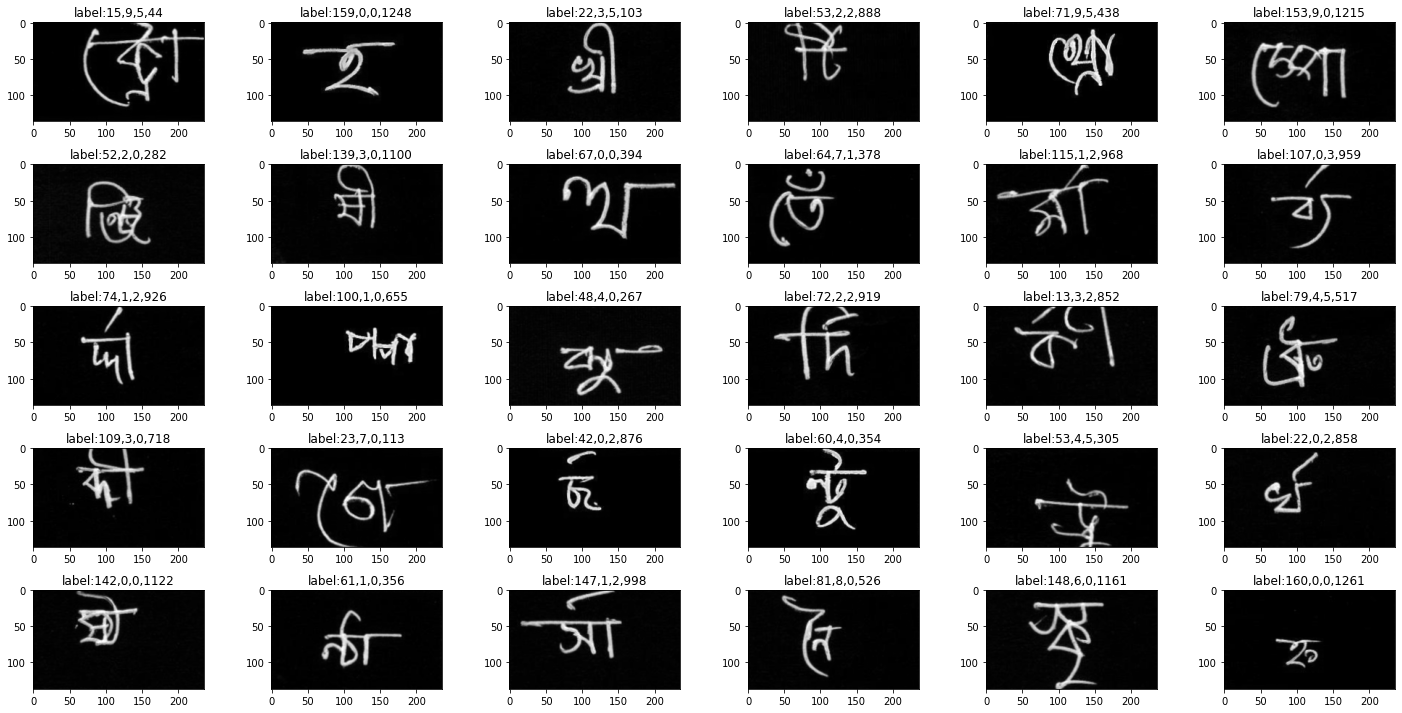

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 10))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, gr, v, c, g = train_dataset[i]
    ax.imshow(image.reshape(image_height, image_width), cmap='gray')
    ax.set_title(f'label:{gr},{v},{c},{g}')
plt.tight_layout()
plt.show()

In [16]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [17]:
# helper --
def make_grid_image(width,height, grid_size=16):

    image = np.zeros((height,width),np.float32)
    for y in range(0,height,2*grid_size):
        for x in range(0,width,2*grid_size):
             image[y: y+grid_size,x:x+grid_size] = 1

    # for y in range(height+grid_size,2*grid_size):
    #     for x in range(width+grid_size,2*grid_size):
    #          image[y: y+grid_size,x:x+grid_size] = 1

    return image

#---

def do_identity(image, magnitude=None):
    return image


# *** geometric ***

def do_random_projective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1) * 0.5*magnitude

    height, width = image.shape[:2]
    x0,y0=0,0
    x1,y1=1,0
    x2,y2=1,1
    x3,y3=0,1

    mode = np.random.choice(['top','bottom','left','right'])
    if mode =='top':
        x0 += mag;   x1 -= mag
    if mode =='bottom':
        x3 += mag;   x2 -= mag
    if mode =='left':
        y0 += mag;   y3 -= mag
    if mode =='right':
        y1 += mag;   y2 -= mag

    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])*[[width, height]]
    d = np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3],])*[[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_perspective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1, (4,2)) * 0.25*magnitude

    height, width = image.shape[:2]
    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])
    d = s+mag
    s *= [[width, height]]
    d *= [[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_scale( image, magnitude=0.5 ):
    s = 1+np.random.uniform(-1, 1)*magnitude*0.5

    height, width = image.shape[:2]
    transform = np.array([
        [s,0,0],
        [0,s,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image



def do_random_shear_x( image, magnitude=0.5 ):
    sx = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1,sx,0],
        [0,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_shear_y( image, magnitude=0.5 ):
    sy = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [sy,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_x(image, magnitude=0.5 ):
    sx = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [sx,0,0],
        [0, 1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_y(image, magnitude=0.5 ):
    sy = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [0,sy,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_rotate(image, magnitude=0.5 ):
    angle = 1+np.random.uniform(-1, 1)*30*magnitude

    height, width = image.shape[:2]
    cx, cy = width // 2, height // 2

    transform = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


#----
def do_random_grid_distortion(image, magnitude=0.5 ):
    num_step = 5
    distort  = magnitude

    # http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
    distort_x = [1 + random.uniform(-distort,distort) for i in range(num_step + 1)]
    distort_y = [1 + random.uniform(-distort,distort) for i in range(num_step + 1)]

    #---
    height, width = image.shape[:2]
    xx = np.zeros(width, np.float32)
    step_x = width // num_step

    prev = 0
    for i, x in enumerate(range(0, width, step_x)):
        start = x
        end   = x + step_x
        if end > width:
            end = width
            cur = width
        else:
            cur = prev + step_x * distort_x[i]

        xx[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    yy = np.zeros(height, np.float32)
    step_y = height // num_step
    prev = 0
    for idx, y in enumerate(range(0, height, step_y)):
        start = y
        end = y + step_y
        if end > height:
            end = height
            cur = height
        else:
            cur = prev + step_y * distort_y[idx]

        yy[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    map_x, map_y = np.meshgrid(xx, yy)
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image

#https://github.com/albumentations-team/albumentations/blob/8b58a3dbd2f35558b3790a1dbff6b42b98e89ea5/albumentations/augmentations/transforms.py

# https://ciechanow.ski/mesh-transforms/
# https://stackoverflow.com/questions/53907633/how-to-warp-an-image-using-deformed-mesh
# http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
def do_random_custom_distortion1(image, magnitude=0.5):
    distort=magnitude*0.3

    height,width = image.shape
    s_x = np.array([0.0, 0.5, 1.0,  0.0, 0.5, 1.0,  0.0, 0.5, 1.0])
    s_y = np.array([0.0, 0.0, 0.0,  0.5, 0.5, 0.5,  1.0, 1.0, 1.0])
    d_x = s_x.copy()
    d_y = s_y.copy()
    d_x[[1,4,7]] += np.random.uniform(-distort,distort, 3)
    d_y[[3,4,5]] += np.random.uniform(-distort,distort, 3)

    s_x = (s_x*width )
    s_y = (s_y*height)
    d_x = (d_x*width )
    d_y = (d_y*height)

    #---
    distort = np.zeros((height,width),np.float32)
    for index in ([4,1,3],[4,1,5],[4,7,3],[4,7,5]):
        point = np.stack([s_x[index],s_y[index]]).T
        qoint = np.stack([d_x[index],d_y[index]]).T

        src  = np.array(point, np.float32)
        dst  = np.array(qoint, np.float32)
        mat  = cv2.getAffineTransform(src, dst)

        point = np.round(point).astype(np.int32)
        x0 = np.min(point[:,0])
        x1 = np.max(point[:,0])
        y0 = np.min(point[:,1])
        y1 = np.max(point[:,1])
        mask = np.zeros((height,width),np.float32)
        mask[y0:y1,x0:x1] = 1

        mask = mask*image
        warp = cv2.warpAffine(mask, mat, (width, height),borderMode=cv2.BORDER_REPLICATE)
        distort = np.maximum(distort,warp)
        #distort = distort+warp

    return distort


# *** intensity ***
def do_random_contrast(image, magnitude=0.5):
    alpha = 1 + random.uniform(-1,1)*magnitude
    image = image.astype(np.float32) * alpha
    image = np.clip(image,0,1)
    return image


def do_random_block_fade(image, magnitude=0.5):
    size  = [0.1, magnitude]

    height,width = image.shape

    #get bounding box
    m = image.copy()
    cv2.rectangle(m,(0,0),(height,width),1,5)
    m = image<0.5
    if m.sum()==0: return image

    m = np.where(m)
    y0,y1,x0,x1 = np.min(m[0]), np.max(m[0]), np.min(m[1]), np.max(m[1])
    w = x1-x0
    h = y1-y0
    if w*h<10: return image

    ew, eh = np.random.uniform(*size,2)
    ew = int(ew*w)
    eh = int(eh*h)

    ex = np.random.randint(0,w-ew)+x0
    ey = np.random.randint(0,h-eh)+y0

    image[ey:ey+eh, ex:ex+ew] *= np.random.uniform(0.1,0.5) #1 #
    image = np.clip(image,0,1)
    return image


# *** noise ***
# https://www.kaggle.com/ren4yu/bengali-morphological-ops-as-image-augmentation
def do_random_erode(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.erode(image, kernel, iterations=1)
    return image

def do_random_dilate(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.dilate(image, kernel, iterations=1)
    return image

def do_random_sprinkle(image, magnitude=0.5):

    size = 16
    num_sprinkle = int(round( 1 + np.random.randint(10)*magnitude ))

    height,width = image.shape
    image = image.copy()
    image_small = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    m   = np.where(image_small>0.25)
    num = len(m[0])
    if num==0: return image

    s = size//2
    i = np.random.choice(num, num_sprinkle)
    for y,x in zip(m[0][i],m[1][i]):
        y=y*4+2
        x=x*4+2
        image[y-s:y+s, x-s:x+s] = 0 #0.5 #1 #
    return image


#https://stackoverflow.com/questions/14435632/impulse-gaussian-and-salt-and-pepper-noise-with-opencv
def do_random_noise(image, magnitude=0.5):
    height,width = image.shape
    noise = np.random.uniform(-1,1,(height,width))*magnitude*0.7
    image = image+noise
    image = np.clip(image,0,1)
    return image



def do_random_line(image, magnitude=0.5):
    num_lines = int(round(1 + np.random.randint(8)*magnitude))

    # ---
    height,width = image.shape
    image = image.copy()

    def line0():
        return (0,0),(width-1,0)

    def line1():
        return (0,height-1),(width-1,height-1)

    def line2():
        return (0,0),(0,height-1)

    def line3():
        return (width-1,0),(width-1,height-1)

    def line4():
        x0,x1 = np.random.choice(width,2)
        return (x0,0),(x1,height-1)

    def line5():
        y0,y1 = np.random.choice(height,2)
        return (0,y0),(width-1,y1)

    for i in range(num_lines):
        p = np.array([1/4,1/4,1/4,1/4,1,1])
        func = np.random.choice([line0,line1,line2,line3,line4,line5],p=p/p.sum())
        (x0,y0),(x1,y1) = func()

        color     = np.random.uniform(0,1)
        thickness = np.random.randint(1,5)
        line_type = np.random.choice([cv2.LINE_AA,cv2.LINE_4,cv2.LINE_8])

        cv2.line(image,(x0,y0),(x1,y1), color, thickness, line_type)

    return image



# batch augmentation that uses pairing, e.g mixup, cutmix, cutout #####################
def make_object_box(image):
    m = image.copy()
    cv2.rectangle(m,(0,0),(236, 137), 0, 10)
    m = m-np.min(m)
    m = m/np.max(m)
    h = m<0.5

    row = np.any(h, axis=1)
    col = np.any(h, axis=0)
    y0, y1 = np.where(row)[0][[0, -1]]
    x0, x1 = np.where(col)[0][[0, -1]]

    return [x0,y0],[x1,y1]




def do_random_batch_mixup(input, onehot):
    batch_size = len(input)

    alpha = 0.4 #0.2  #0.2,0.4
    gamma = np.random.beta(alpha, alpha, batch_size)
    gamma = np.maximum(1-gamma,gamma)

    # #mixup https://github.com/moskomule/mixup.pytorch/blob/master/main.py
    gamma = torch.from_numpy(gamma).float().to(input.device)
    perm  = torch.randperm(batch_size).to(input.device)
    perm_input  = input[perm]
    perm_onehot = [t[perm] for t in onehot]

    gamma = gamma.view(batch_size,1,1,1)
    mix_input  = gamma*input + (1-gamma)*perm_input
    gamma = gamma.view(batch_size,1)
    mix_onehot = [gamma*t + (1-gamma)*perm_t for t,perm_t in zip(onehot,perm_onehot)]

    return mix_input, mix_onehot, (perm_input, perm_onehot)


def do_random_batch_cutout(input, onehot):
    batch_size,C,H,W = input.shape

    mask = np.ones((batch_size,C,H,W ), np.float32)
    for b in range(batch_size):

        length = int(np.random.uniform(0.1,0.5)*min(H,W))
        y = np.random.randint(H)
        x = np.random.randint(W)

        y0 = np.clip(y - length // 2, 0, H)
        y1 = np.clip(y + length // 2, 0, H)
        x0 = np.clip(x - length // 2, 0, W)
        x1 = np.clip(x + length // 2, 0, W)
        mask[b, :, y0: y1, x0: x1] = 0
    mask  = torch.from_numpy(mask).to(input.device)

    input = input*mask
    return input, onehot, None

In [18]:
def valid_augment(image):
    return image


def train_augment(image):
    regularization_decision = np.random.rand()
    if regularization_decision < 2/3.0: # grid mask
        image = A.OneOf([
            GridMask(num_grid=(2,3), mode=0, rotate=15, always_apply=True),
            #GridMask(num_grid=(2,3), mode=2, rotate=15, always_apply=True),
        ], p=1)(image=image)['image']
    else: # normal aug
        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_projective(image, 0.4),
            lambda image : do_random_perspective(image, 0.4),
            lambda image : do_random_scale(image, 0.4),
            lambda image : do_random_rotate(image, 0.4),
            lambda image : do_random_shear_x(image, 0.5),
            lambda image : do_random_shear_y(image, 0.4),
            lambda image : do_random_stretch_x(image, 0.5),
            lambda image : do_random_stretch_y(image, 0.5),
            lambda image : do_random_grid_distortion(image, 0.4),
            lambda image : do_random_custom_distortion1(image, 0.5),
        ],1):
            image = op(image)

        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_erode(image, 0.4),
            lambda image : do_random_dilate(image, 0.4),
            lambda image : do_random_sprinkle(image, 0.5),
            lambda image : do_random_line(image, 0.5),
        ],1):
            image = op(image)

        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_contrast(image, 0.5),
            lambda image : do_random_block_fade(image, 0.5),
        ],1):
            image = op(image)

        #image = do_random_pad_crop(image, 3)
    return image

In [19]:
train_dataset = BengaliAIDataset(train_images, train_labels, transform=train_augment)

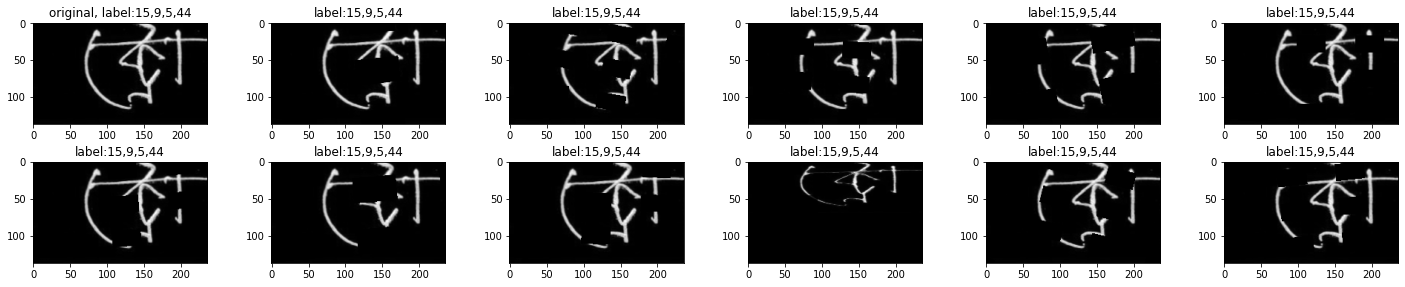

In [20]:
nrow, ncol = 2, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 4))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, aug_image, gr, v, c, g = train_dataset[0]
    if i == 0:
        #print((image==image).sum()/image.shape[1]*image.shape[2])
        ax.imshow(image.reshape(image_height,image_width), cmap='gray')
        ax.set_title(f'original, label:{gr},{v},{c},{g}')
    else:
        #print((image==aug_image).sum()/(image.shape[1]*image.shape[2]))
        #print(image.shape[1]*image.shape[2])
        #print((image==aug_image).sum()/image.shape[1]*image.shape[2])
        ax.imshow(aug_image.reshape(image_height,image_width), cmap='gray')
        ax.set_title(f'label:{gr},{v},{c},{g}')
plt.tight_layout()
plt.show()

In [21]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [22]:
IMAGE_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGE_RGB_STD  = [0.229, 0.224, 0.225]
PRETRAIN_FILE = '../pretrained_model/se_resnext50_32x4d-a260b3a4.pth'
class_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic','grapheme_enc']
NUM_CLASS = [train[cc].nunique() for cc in class_cols]
print('NUM_CLASS:', NUM_CLASS)

NUM_CLASS: [168, 11, 7, 1295]


In [23]:
CONVERSION=[
 'block0.0.weight',	(64, 3, 7, 7),	 'layer0.conv1.weight',	(64, 3, 7, 7),
 'block0.1.weight',	(64,),	 'layer0.bn1.weight',	(64,),
 'block0.1.bias',	(64,),	 'layer0.bn1.bias',	(64,),
 'block0.1.running_mean',	(64,),	 'layer0.bn1.running_mean',	(64,),
 'block0.1.running_var',	(64,),	 'layer0.bn1.running_var',	(64,),
 'block1.0.conv_bn1.conv.weight',	(128, 64, 1, 1),	 'layer1.0.conv1.weight',	(128, 64, 1, 1),
 'block1.0.conv_bn1.bn.weight',	(128,),	 'layer1.0.bn1.weight',	(128,),
 'block1.0.conv_bn1.bn.bias',	(128,),	 'layer1.0.bn1.bias',	(128,),
 'block1.0.conv_bn1.bn.running_mean',	(128,),	 'layer1.0.bn1.running_mean',	(128,),
 'block1.0.conv_bn1.bn.running_var',	(128,),	 'layer1.0.bn1.running_var',	(128,),
 'block1.0.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.0.conv2.weight',	(128, 4, 3, 3),
 'block1.0.conv_bn2.bn.weight',	(128,),	 'layer1.0.bn2.weight',	(128,),
 'block1.0.conv_bn2.bn.bias',	(128,),	 'layer1.0.bn2.bias',	(128,),
 'block1.0.conv_bn2.bn.running_mean',	(128,),	 'layer1.0.bn2.running_mean',	(128,),
 'block1.0.conv_bn2.bn.running_var',	(128,),	 'layer1.0.bn2.running_var',	(128,),
 'block1.0.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.0.conv3.weight',	(256, 128, 1, 1),
 'block1.0.conv_bn3.bn.weight',	(256,),	 'layer1.0.bn3.weight',	(256,),
 'block1.0.conv_bn3.bn.bias',	(256,),	 'layer1.0.bn3.bias',	(256,),
 'block1.0.conv_bn3.bn.running_mean',	(256,),	 'layer1.0.bn3.running_mean',	(256,),
 'block1.0.conv_bn3.bn.running_var',	(256,),	 'layer1.0.bn3.running_var',	(256,),
 'block1.0.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.0.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.0.scale.fc1.bias',	(16,),	 'layer1.0.se_module.fc1.bias',	(16,),
 'block1.0.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.0.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.0.scale.fc2.bias',	(256,),	 'layer1.0.se_module.fc2.bias',	(256,),
 'block1.0.shortcut.conv.weight',	(256, 64, 1, 1),	 'layer1.0.downsample.0.weight',	(256, 64, 1, 1),
 'block1.0.shortcut.bn.weight',	(256,),	 'layer1.0.downsample.1.weight',	(256,),
 'block1.0.shortcut.bn.bias',	(256,),	 'layer1.0.downsample.1.bias',	(256,),
 'block1.0.shortcut.bn.running_mean',	(256,),	 'layer1.0.downsample.1.running_mean',	(256,),
 'block1.0.shortcut.bn.running_var',	(256,),	 'layer1.0.downsample.1.running_var',	(256,),
 'block1.1.conv_bn1.conv.weight',	(128, 256, 1, 1),	 'layer1.1.conv1.weight',	(128, 256, 1, 1),
 'block1.1.conv_bn1.bn.weight',	(128,),	 'layer1.1.bn1.weight',	(128,),
 'block1.1.conv_bn1.bn.bias',	(128,),	 'layer1.1.bn1.bias',	(128,),
 'block1.1.conv_bn1.bn.running_mean',	(128,),	 'layer1.1.bn1.running_mean',	(128,),
 'block1.1.conv_bn1.bn.running_var',	(128,),	 'layer1.1.bn1.running_var',	(128,),
 'block1.1.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.1.conv2.weight',	(128, 4, 3, 3),
 'block1.1.conv_bn2.bn.weight',	(128,),	 'layer1.1.bn2.weight',	(128,),
 'block1.1.conv_bn2.bn.bias',	(128,),	 'layer1.1.bn2.bias',	(128,),
 'block1.1.conv_bn2.bn.running_mean',	(128,),	 'layer1.1.bn2.running_mean',	(128,),
 'block1.1.conv_bn2.bn.running_var',	(128,),	 'layer1.1.bn2.running_var',	(128,),
 'block1.1.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.1.conv3.weight',	(256, 128, 1, 1),
 'block1.1.conv_bn3.bn.weight',	(256,),	 'layer1.1.bn3.weight',	(256,),
 'block1.1.conv_bn3.bn.bias',	(256,),	 'layer1.1.bn3.bias',	(256,),
 'block1.1.conv_bn3.bn.running_mean',	(256,),	 'layer1.1.bn3.running_mean',	(256,),
 'block1.1.conv_bn3.bn.running_var',	(256,),	 'layer1.1.bn3.running_var',	(256,),
 'block1.1.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.1.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.1.scale.fc1.bias',	(16,),	 'layer1.1.se_module.fc1.bias',	(16,),
 'block1.1.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.1.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.1.scale.fc2.bias',	(256,),	 'layer1.1.se_module.fc2.bias',	(256,),
 'block1.2.conv_bn1.conv.weight',	(128, 256, 1, 1),	 'layer1.2.conv1.weight',	(128, 256, 1, 1),
 'block1.2.conv_bn1.bn.weight',	(128,),	 'layer1.2.bn1.weight',	(128,),
 'block1.2.conv_bn1.bn.bias',	(128,),	 'layer1.2.bn1.bias',	(128,),
 'block1.2.conv_bn1.bn.running_mean',	(128,),	 'layer1.2.bn1.running_mean',	(128,),
 'block1.2.conv_bn1.bn.running_var',	(128,),	 'layer1.2.bn1.running_var',	(128,),
 'block1.2.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.2.conv2.weight',	(128, 4, 3, 3),
 'block1.2.conv_bn2.bn.weight',	(128,),	 'layer1.2.bn2.weight',	(128,),
 'block1.2.conv_bn2.bn.bias',	(128,),	 'layer1.2.bn2.bias',	(128,),
 'block1.2.conv_bn2.bn.running_mean',	(128,),	 'layer1.2.bn2.running_mean',	(128,),
 'block1.2.conv_bn2.bn.running_var',	(128,),	 'layer1.2.bn2.running_var',	(128,),
 'block1.2.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.2.conv3.weight',	(256, 128, 1, 1),
 'block1.2.conv_bn3.bn.weight',	(256,),	 'layer1.2.bn3.weight',	(256,),
 'block1.2.conv_bn3.bn.bias',	(256,),	 'layer1.2.bn3.bias',	(256,),
 'block1.2.conv_bn3.bn.running_mean',	(256,),	 'layer1.2.bn3.running_mean',	(256,),
 'block1.2.conv_bn3.bn.running_var',	(256,),	 'layer1.2.bn3.running_var',	(256,),
 'block1.2.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.2.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.2.scale.fc1.bias',	(16,),	 'layer1.2.se_module.fc1.bias',	(16,),
 'block1.2.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.2.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.2.scale.fc2.bias',	(256,),	 'layer1.2.se_module.fc2.bias',	(256,),
 'block2.0.conv_bn1.conv.weight',	(256, 256, 1, 1),	 'layer2.0.conv1.weight',	(256, 256, 1, 1),
 'block2.0.conv_bn1.bn.weight',	(256,),	 'layer2.0.bn1.weight',	(256,),
 'block2.0.conv_bn1.bn.bias',	(256,),	 'layer2.0.bn1.bias',	(256,),
 'block2.0.conv_bn1.bn.running_mean',	(256,),	 'layer2.0.bn1.running_mean',	(256,),
 'block2.0.conv_bn1.bn.running_var',	(256,),	 'layer2.0.bn1.running_var',	(256,),
 'block2.0.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.0.conv2.weight',	(256, 8, 3, 3),
 'block2.0.conv_bn2.bn.weight',	(256,),	 'layer2.0.bn2.weight',	(256,),
 'block2.0.conv_bn2.bn.bias',	(256,),	 'layer2.0.bn2.bias',	(256,),
 'block2.0.conv_bn2.bn.running_mean',	(256,),	 'layer2.0.bn2.running_mean',	(256,),
 'block2.0.conv_bn2.bn.running_var',	(256,),	 'layer2.0.bn2.running_var',	(256,),
 'block2.0.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.0.conv3.weight',	(512, 256, 1, 1),
 'block2.0.conv_bn3.bn.weight',	(512,),	 'layer2.0.bn3.weight',	(512,),
 'block2.0.conv_bn3.bn.bias',	(512,),	 'layer2.0.bn3.bias',	(512,),
 'block2.0.conv_bn3.bn.running_mean',	(512,),	 'layer2.0.bn3.running_mean',	(512,),
 'block2.0.conv_bn3.bn.running_var',	(512,),	 'layer2.0.bn3.running_var',	(512,),
 'block2.0.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.0.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.0.scale.fc1.bias',	(32,),	 'layer2.0.se_module.fc1.bias',	(32,),
 'block2.0.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.0.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.0.scale.fc2.bias',	(512,),	 'layer2.0.se_module.fc2.bias',	(512,),
 'block2.0.shortcut.conv.weight',	(512, 256, 1, 1),	 'layer2.0.downsample.0.weight',	(512, 256, 1, 1),
 'block2.0.shortcut.bn.weight',	(512,),	 'layer2.0.downsample.1.weight',	(512,),
 'block2.0.shortcut.bn.bias',	(512,),	 'layer2.0.downsample.1.bias',	(512,),
 'block2.0.shortcut.bn.running_mean',	(512,),	 'layer2.0.downsample.1.running_mean',	(512,),
 'block2.0.shortcut.bn.running_var',	(512,),	 'layer2.0.downsample.1.running_var',	(512,),
 'block2.1.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.1.conv1.weight',	(256, 512, 1, 1),
 'block2.1.conv_bn1.bn.weight',	(256,),	 'layer2.1.bn1.weight',	(256,),
 'block2.1.conv_bn1.bn.bias',	(256,),	 'layer2.1.bn1.bias',	(256,),
 'block2.1.conv_bn1.bn.running_mean',	(256,),	 'layer2.1.bn1.running_mean',	(256,),
 'block2.1.conv_bn1.bn.running_var',	(256,),	 'layer2.1.bn1.running_var',	(256,),
 'block2.1.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.1.conv2.weight',	(256, 8, 3, 3),
 'block2.1.conv_bn2.bn.weight',	(256,),	 'layer2.1.bn2.weight',	(256,),
 'block2.1.conv_bn2.bn.bias',	(256,),	 'layer2.1.bn2.bias',	(256,),
 'block2.1.conv_bn2.bn.running_mean',	(256,),	 'layer2.1.bn2.running_mean',	(256,),
 'block2.1.conv_bn2.bn.running_var',	(256,),	 'layer2.1.bn2.running_var',	(256,),
 'block2.1.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.1.conv3.weight',	(512, 256, 1, 1),
 'block2.1.conv_bn3.bn.weight',	(512,),	 'layer2.1.bn3.weight',	(512,),
 'block2.1.conv_bn3.bn.bias',	(512,),	 'layer2.1.bn3.bias',	(512,),
 'block2.1.conv_bn3.bn.running_mean',	(512,),	 'layer2.1.bn3.running_mean',	(512,),
 'block2.1.conv_bn3.bn.running_var',	(512,),	 'layer2.1.bn3.running_var',	(512,),
 'block2.1.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.1.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.1.scale.fc1.bias',	(32,),	 'layer2.1.se_module.fc1.bias',	(32,),
 'block2.1.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.1.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.1.scale.fc2.bias',	(512,),	 'layer2.1.se_module.fc2.bias',	(512,),
 'block2.2.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.2.conv1.weight',	(256, 512, 1, 1),
 'block2.2.conv_bn1.bn.weight',	(256,),	 'layer2.2.bn1.weight',	(256,),
 'block2.2.conv_bn1.bn.bias',	(256,),	 'layer2.2.bn1.bias',	(256,),
 'block2.2.conv_bn1.bn.running_mean',	(256,),	 'layer2.2.bn1.running_mean',	(256,),
 'block2.2.conv_bn1.bn.running_var',	(256,),	 'layer2.2.bn1.running_var',	(256,),
 'block2.2.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.2.conv2.weight',	(256, 8, 3, 3),
 'block2.2.conv_bn2.bn.weight',	(256,),	 'layer2.2.bn2.weight',	(256,),
 'block2.2.conv_bn2.bn.bias',	(256,),	 'layer2.2.bn2.bias',	(256,),
 'block2.2.conv_bn2.bn.running_mean',	(256,),	 'layer2.2.bn2.running_mean',	(256,),
 'block2.2.conv_bn2.bn.running_var',	(256,),	 'layer2.2.bn2.running_var',	(256,),
 'block2.2.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.2.conv3.weight',	(512, 256, 1, 1),
 'block2.2.conv_bn3.bn.weight',	(512,),	 'layer2.2.bn3.weight',	(512,),
 'block2.2.conv_bn3.bn.bias',	(512,),	 'layer2.2.bn3.bias',	(512,),
 'block2.2.conv_bn3.bn.running_mean',	(512,),	 'layer2.2.bn3.running_mean',	(512,),
 'block2.2.conv_bn3.bn.running_var',	(512,),	 'layer2.2.bn3.running_var',	(512,),
 'block2.2.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.2.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.2.scale.fc1.bias',	(32,),	 'layer2.2.se_module.fc1.bias',	(32,),
 'block2.2.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.2.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.2.scale.fc2.bias',	(512,),	 'layer2.2.se_module.fc2.bias',	(512,),
 'block2.3.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.3.conv1.weight',	(256, 512, 1, 1),
 'block2.3.conv_bn1.bn.weight',	(256,),	 'layer2.3.bn1.weight',	(256,),
 'block2.3.conv_bn1.bn.bias',	(256,),	 'layer2.3.bn1.bias',	(256,),
 'block2.3.conv_bn1.bn.running_mean',	(256,),	 'layer2.3.bn1.running_mean',	(256,),
 'block2.3.conv_bn1.bn.running_var',	(256,),	 'layer2.3.bn1.running_var',	(256,),
 'block2.3.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.3.conv2.weight',	(256, 8, 3, 3),
 'block2.3.conv_bn2.bn.weight',	(256,),	 'layer2.3.bn2.weight',	(256,),
 'block2.3.conv_bn2.bn.bias',	(256,),	 'layer2.3.bn2.bias',	(256,),
 'block2.3.conv_bn2.bn.running_mean',	(256,),	 'layer2.3.bn2.running_mean',	(256,),
 'block2.3.conv_bn2.bn.running_var',	(256,),	 'layer2.3.bn2.running_var',	(256,),
 'block2.3.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.3.conv3.weight',	(512, 256, 1, 1),
 'block2.3.conv_bn3.bn.weight',	(512,),	 'layer2.3.bn3.weight',	(512,),
 'block2.3.conv_bn3.bn.bias',	(512,),	 'layer2.3.bn3.bias',	(512,),
 'block2.3.conv_bn3.bn.running_mean',	(512,),	 'layer2.3.bn3.running_mean',	(512,),
 'block2.3.conv_bn3.bn.running_var',	(512,),	 'layer2.3.bn3.running_var',	(512,),
 'block2.3.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.3.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.3.scale.fc1.bias',	(32,),	 'layer2.3.se_module.fc1.bias',	(32,),
 'block2.3.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.3.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.3.scale.fc2.bias',	(512,),	 'layer2.3.se_module.fc2.bias',	(512,),
 'block3.0.conv_bn1.conv.weight',	(512, 512, 1, 1),	 'layer3.0.conv1.weight',	(512, 512, 1, 1),
 'block3.0.conv_bn1.bn.weight',	(512,),	 'layer3.0.bn1.weight',	(512,),
 'block3.0.conv_bn1.bn.bias',	(512,),	 'layer3.0.bn1.bias',	(512,),
 'block3.0.conv_bn1.bn.running_mean',	(512,),	 'layer3.0.bn1.running_mean',	(512,),
 'block3.0.conv_bn1.bn.running_var',	(512,),	 'layer3.0.bn1.running_var',	(512,),
 'block3.0.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.0.conv2.weight',	(512, 16, 3, 3),
 'block3.0.conv_bn2.bn.weight',	(512,),	 'layer3.0.bn2.weight',	(512,),
 'block3.0.conv_bn2.bn.bias',	(512,),	 'layer3.0.bn2.bias',	(512,),
 'block3.0.conv_bn2.bn.running_mean',	(512,),	 'layer3.0.bn2.running_mean',	(512,),
 'block3.0.conv_bn2.bn.running_var',	(512,),	 'layer3.0.bn2.running_var',	(512,),
 'block3.0.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.0.conv3.weight',	(1024, 512, 1, 1),
 'block3.0.conv_bn3.bn.weight',	(1024,),	 'layer3.0.bn3.weight',	(1024,),
 'block3.0.conv_bn3.bn.bias',	(1024,),	 'layer3.0.bn3.bias',	(1024,),
 'block3.0.conv_bn3.bn.running_mean',	(1024,),	 'layer3.0.bn3.running_mean',	(1024,),
 'block3.0.conv_bn3.bn.running_var',	(1024,),	 'layer3.0.bn3.running_var',	(1024,),
 'block3.0.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.0.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.0.scale.fc1.bias',	(64,),	 'layer3.0.se_module.fc1.bias',	(64,),
 'block3.0.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.0.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.0.scale.fc2.bias',	(1024,),	 'layer3.0.se_module.fc2.bias',	(1024,),
 'block3.0.shortcut.conv.weight',	(1024, 512, 1, 1),	 'layer3.0.downsample.0.weight',	(1024, 512, 1, 1),
 'block3.0.shortcut.bn.weight',	(1024,),	 'layer3.0.downsample.1.weight',	(1024,),
 'block3.0.shortcut.bn.bias',	(1024,),	 'layer3.0.downsample.1.bias',	(1024,),
 'block3.0.shortcut.bn.running_mean',	(1024,),	 'layer3.0.downsample.1.running_mean',	(1024,),
 'block3.0.shortcut.bn.running_var',	(1024,),	 'layer3.0.downsample.1.running_var',	(1024,),
 'block3.1.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.1.conv1.weight',	(512, 1024, 1, 1),
 'block3.1.conv_bn1.bn.weight',	(512,),	 'layer3.1.bn1.weight',	(512,),
 'block3.1.conv_bn1.bn.bias',	(512,),	 'layer3.1.bn1.bias',	(512,),
 'block3.1.conv_bn1.bn.running_mean',	(512,),	 'layer3.1.bn1.running_mean',	(512,),
 'block3.1.conv_bn1.bn.running_var',	(512,),	 'layer3.1.bn1.running_var',	(512,),
 'block3.1.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.1.conv2.weight',	(512, 16, 3, 3),
 'block3.1.conv_bn2.bn.weight',	(512,),	 'layer3.1.bn2.weight',	(512,),
 'block3.1.conv_bn2.bn.bias',	(512,),	 'layer3.1.bn2.bias',	(512,),
 'block3.1.conv_bn2.bn.running_mean',	(512,),	 'layer3.1.bn2.running_mean',	(512,),
 'block3.1.conv_bn2.bn.running_var',	(512,),	 'layer3.1.bn2.running_var',	(512,),
 'block3.1.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.1.conv3.weight',	(1024, 512, 1, 1),
 'block3.1.conv_bn3.bn.weight',	(1024,),	 'layer3.1.bn3.weight',	(1024,),
 'block3.1.conv_bn3.bn.bias',	(1024,),	 'layer3.1.bn3.bias',	(1024,),
 'block3.1.conv_bn3.bn.running_mean',	(1024,),	 'layer3.1.bn3.running_mean',	(1024,),
 'block3.1.conv_bn3.bn.running_var',	(1024,),	 'layer3.1.bn3.running_var',	(1024,),
 'block3.1.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.1.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.1.scale.fc1.bias',	(64,),	 'layer3.1.se_module.fc1.bias',	(64,),
 'block3.1.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.1.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.1.scale.fc2.bias',	(1024,),	 'layer3.1.se_module.fc2.bias',	(1024,),
 'block3.2.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.2.conv1.weight',	(512, 1024, 1, 1),
 'block3.2.conv_bn1.bn.weight',	(512,),	 'layer3.2.bn1.weight',	(512,),
 'block3.2.conv_bn1.bn.bias',	(512,),	 'layer3.2.bn1.bias',	(512,),
 'block3.2.conv_bn1.bn.running_mean',	(512,),	 'layer3.2.bn1.running_mean',	(512,),
 'block3.2.conv_bn1.bn.running_var',	(512,),	 'layer3.2.bn1.running_var',	(512,),
 'block3.2.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.2.conv2.weight',	(512, 16, 3, 3),
 'block3.2.conv_bn2.bn.weight',	(512,),	 'layer3.2.bn2.weight',	(512,),
 'block3.2.conv_bn2.bn.bias',	(512,),	 'layer3.2.bn2.bias',	(512,),
 'block3.2.conv_bn2.bn.running_mean',	(512,),	 'layer3.2.bn2.running_mean',	(512,),
 'block3.2.conv_bn2.bn.running_var',	(512,),	 'layer3.2.bn2.running_var',	(512,),
 'block3.2.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.2.conv3.weight',	(1024, 512, 1, 1),
 'block3.2.conv_bn3.bn.weight',	(1024,),	 'layer3.2.bn3.weight',	(1024,),
 'block3.2.conv_bn3.bn.bias',	(1024,),	 'layer3.2.bn3.bias',	(1024,),
 'block3.2.conv_bn3.bn.running_mean',	(1024,),	 'layer3.2.bn3.running_mean',	(1024,),
 'block3.2.conv_bn3.bn.running_var',	(1024,),	 'layer3.2.bn3.running_var',	(1024,),
 'block3.2.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.2.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.2.scale.fc1.bias',	(64,),	 'layer3.2.se_module.fc1.bias',	(64,),
 'block3.2.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.2.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.2.scale.fc2.bias',	(1024,),	 'layer3.2.se_module.fc2.bias',	(1024,),
 'block3.3.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.3.conv1.weight',	(512, 1024, 1, 1),
 'block3.3.conv_bn1.bn.weight',	(512,),	 'layer3.3.bn1.weight',	(512,),
 'block3.3.conv_bn1.bn.bias',	(512,),	 'layer3.3.bn1.bias',	(512,),
 'block3.3.conv_bn1.bn.running_mean',	(512,),	 'layer3.3.bn1.running_mean',	(512,),
 'block3.3.conv_bn1.bn.running_var',	(512,),	 'layer3.3.bn1.running_var',	(512,),
 'block3.3.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.3.conv2.weight',	(512, 16, 3, 3),
 'block3.3.conv_bn2.bn.weight',	(512,),	 'layer3.3.bn2.weight',	(512,),
 'block3.3.conv_bn2.bn.bias',	(512,),	 'layer3.3.bn2.bias',	(512,),
 'block3.3.conv_bn2.bn.running_mean',	(512,),	 'layer3.3.bn2.running_mean',	(512,),
 'block3.3.conv_bn2.bn.running_var',	(512,),	 'layer3.3.bn2.running_var',	(512,),
 'block3.3.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.3.conv3.weight',	(1024, 512, 1, 1),
 'block3.3.conv_bn3.bn.weight',	(1024,),	 'layer3.3.bn3.weight',	(1024,),
 'block3.3.conv_bn3.bn.bias',	(1024,),	 'layer3.3.bn3.bias',	(1024,),
 'block3.3.conv_bn3.bn.running_mean',	(1024,),	 'layer3.3.bn3.running_mean',	(1024,),
 'block3.3.conv_bn3.bn.running_var',	(1024,),	 'layer3.3.bn3.running_var',	(1024,),
 'block3.3.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.3.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.3.scale.fc1.bias',	(64,),	 'layer3.3.se_module.fc1.bias',	(64,),
 'block3.3.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.3.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.3.scale.fc2.bias',	(1024,),	 'layer3.3.se_module.fc2.bias',	(1024,),
 'block3.4.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.4.conv1.weight',	(512, 1024, 1, 1),
 'block3.4.conv_bn1.bn.weight',	(512,),	 'layer3.4.bn1.weight',	(512,),
 'block3.4.conv_bn1.bn.bias',	(512,),	 'layer3.4.bn1.bias',	(512,),
 'block3.4.conv_bn1.bn.running_mean',	(512,),	 'layer3.4.bn1.running_mean',	(512,),
 'block3.4.conv_bn1.bn.running_var',	(512,),	 'layer3.4.bn1.running_var',	(512,),
 'block3.4.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.4.conv2.weight',	(512, 16, 3, 3),
 'block3.4.conv_bn2.bn.weight',	(512,),	 'layer3.4.bn2.weight',	(512,),
 'block3.4.conv_bn2.bn.bias',	(512,),	 'layer3.4.bn2.bias',	(512,),
 'block3.4.conv_bn2.bn.running_mean',	(512,),	 'layer3.4.bn2.running_mean',	(512,),
 'block3.4.conv_bn2.bn.running_var',	(512,),	 'layer3.4.bn2.running_var',	(512,),
 'block3.4.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.4.conv3.weight',	(1024, 512, 1, 1),
 'block3.4.conv_bn3.bn.weight',	(1024,),	 'layer3.4.bn3.weight',	(1024,),
 'block3.4.conv_bn3.bn.bias',	(1024,),	 'layer3.4.bn3.bias',	(1024,),
 'block3.4.conv_bn3.bn.running_mean',	(1024,),	 'layer3.4.bn3.running_mean',	(1024,),
 'block3.4.conv_bn3.bn.running_var',	(1024,),	 'layer3.4.bn3.running_var',	(1024,),
 'block3.4.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.4.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.4.scale.fc1.bias',	(64,),	 'layer3.4.se_module.fc1.bias',	(64,),
 'block3.4.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.4.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.4.scale.fc2.bias',	(1024,),	 'layer3.4.se_module.fc2.bias',	(1024,),
 'block3.5.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.5.conv1.weight',	(512, 1024, 1, 1),
 'block3.5.conv_bn1.bn.weight',	(512,),	 'layer3.5.bn1.weight',	(512,),
 'block3.5.conv_bn1.bn.bias',	(512,),	 'layer3.5.bn1.bias',	(512,),
 'block3.5.conv_bn1.bn.running_mean',	(512,),	 'layer3.5.bn1.running_mean',	(512,),
 'block3.5.conv_bn1.bn.running_var',	(512,),	 'layer3.5.bn1.running_var',	(512,),
 'block3.5.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.5.conv2.weight',	(512, 16, 3, 3),
 'block3.5.conv_bn2.bn.weight',	(512,),	 'layer3.5.bn2.weight',	(512,),
 'block3.5.conv_bn2.bn.bias',	(512,),	 'layer3.5.bn2.bias',	(512,),
 'block3.5.conv_bn2.bn.running_mean',	(512,),	 'layer3.5.bn2.running_mean',	(512,),
 'block3.5.conv_bn2.bn.running_var',	(512,),	 'layer3.5.bn2.running_var',	(512,),
 'block3.5.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.5.conv3.weight',	(1024, 512, 1, 1),
 'block3.5.conv_bn3.bn.weight',	(1024,),	 'layer3.5.bn3.weight',	(1024,),
 'block3.5.conv_bn3.bn.bias',	(1024,),	 'layer3.5.bn3.bias',	(1024,),
 'block3.5.conv_bn3.bn.running_mean',	(1024,),	 'layer3.5.bn3.running_mean',	(1024,),
 'block3.5.conv_bn3.bn.running_var',	(1024,),	 'layer3.5.bn3.running_var',	(1024,),
 'block3.5.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.5.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.5.scale.fc1.bias',	(64,),	 'layer3.5.se_module.fc1.bias',	(64,),
 'block3.5.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.5.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.5.scale.fc2.bias',	(1024,),	 'layer3.5.se_module.fc2.bias',	(1024,),
 'block4.0.conv_bn1.conv.weight',	(1024, 1024, 1, 1),	 'layer4.0.conv1.weight',	(1024, 1024, 1, 1),
 'block4.0.conv_bn1.bn.weight',	(1024,),	 'layer4.0.bn1.weight',	(1024,),
 'block4.0.conv_bn1.bn.bias',	(1024,),	 'layer4.0.bn1.bias',	(1024,),
 'block4.0.conv_bn1.bn.running_mean',	(1024,),	 'layer4.0.bn1.running_mean',	(1024,),
 'block4.0.conv_bn1.bn.running_var',	(1024,),	 'layer4.0.bn1.running_var',	(1024,),
 'block4.0.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.0.conv2.weight',	(1024, 32, 3, 3),
 'block4.0.conv_bn2.bn.weight',	(1024,),	 'layer4.0.bn2.weight',	(1024,),
 'block4.0.conv_bn2.bn.bias',	(1024,),	 'layer4.0.bn2.bias',	(1024,),
 'block4.0.conv_bn2.bn.running_mean',	(1024,),	 'layer4.0.bn2.running_mean',	(1024,),
 'block4.0.conv_bn2.bn.running_var',	(1024,),	 'layer4.0.bn2.running_var',	(1024,),
 'block4.0.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.0.conv3.weight',	(2048, 1024, 1, 1),
 'block4.0.conv_bn3.bn.weight',	(2048,),	 'layer4.0.bn3.weight',	(2048,),
 'block4.0.conv_bn3.bn.bias',	(2048,),	 'layer4.0.bn3.bias',	(2048,),
 'block4.0.conv_bn3.bn.running_mean',	(2048,),	 'layer4.0.bn3.running_mean',	(2048,),
 'block4.0.conv_bn3.bn.running_var',	(2048,),	 'layer4.0.bn3.running_var',	(2048,),
 'block4.0.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.0.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.0.scale.fc1.bias',	(128,),	 'layer4.0.se_module.fc1.bias',	(128,),
 'block4.0.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.0.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.0.scale.fc2.bias',	(2048,),	 'layer4.0.se_module.fc2.bias',	(2048,),
 'block4.0.shortcut.conv.weight',	(2048, 1024, 1, 1),	 'layer4.0.downsample.0.weight',	(2048, 1024, 1, 1),
 'block4.0.shortcut.bn.weight',	(2048,),	 'layer4.0.downsample.1.weight',	(2048,),
 'block4.0.shortcut.bn.bias',	(2048,),	 'layer4.0.downsample.1.bias',	(2048,),
 'block4.0.shortcut.bn.running_mean',	(2048,),	 'layer4.0.downsample.1.running_mean',	(2048,),
 'block4.0.shortcut.bn.running_var',	(2048,),	 'layer4.0.downsample.1.running_var',	(2048,),
 'block4.1.conv_bn1.conv.weight',	(1024, 2048, 1, 1),	 'layer4.1.conv1.weight',	(1024, 2048, 1, 1),
 'block4.1.conv_bn1.bn.weight',	(1024,),	 'layer4.1.bn1.weight',	(1024,),
 'block4.1.conv_bn1.bn.bias',	(1024,),	 'layer4.1.bn1.bias',	(1024,),
 'block4.1.conv_bn1.bn.running_mean',	(1024,),	 'layer4.1.bn1.running_mean',	(1024,),
 'block4.1.conv_bn1.bn.running_var',	(1024,),	 'layer4.1.bn1.running_var',	(1024,),
 'block4.1.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.1.conv2.weight',	(1024, 32, 3, 3),
 'block4.1.conv_bn2.bn.weight',	(1024,),	 'layer4.1.bn2.weight',	(1024,),
 'block4.1.conv_bn2.bn.bias',	(1024,),	 'layer4.1.bn2.bias',	(1024,),
 'block4.1.conv_bn2.bn.running_mean',	(1024,),	 'layer4.1.bn2.running_mean',	(1024,),
 'block4.1.conv_bn2.bn.running_var',	(1024,),	 'layer4.1.bn2.running_var',	(1024,),
 'block4.1.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.1.conv3.weight',	(2048, 1024, 1, 1),
 'block4.1.conv_bn3.bn.weight',	(2048,),	 'layer4.1.bn3.weight',	(2048,),
 'block4.1.conv_bn3.bn.bias',	(2048,),	 'layer4.1.bn3.bias',	(2048,),
 'block4.1.conv_bn3.bn.running_mean',	(2048,),	 'layer4.1.bn3.running_mean',	(2048,),
 'block4.1.conv_bn3.bn.running_var',	(2048,),	 'layer4.1.bn3.running_var',	(2048,),
 'block4.1.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.1.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.1.scale.fc1.bias',	(128,),	 'layer4.1.se_module.fc1.bias',	(128,),
 'block4.1.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.1.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.1.scale.fc2.bias',	(2048,),	 'layer4.1.se_module.fc2.bias',	(2048,),
 'block4.2.conv_bn1.conv.weight',	(1024, 2048, 1, 1),	 'layer4.2.conv1.weight',	(1024, 2048, 1, 1),
 'block4.2.conv_bn1.bn.weight',	(1024,),	 'layer4.2.bn1.weight',	(1024,),
 'block4.2.conv_bn1.bn.bias',	(1024,),	 'layer4.2.bn1.bias',	(1024,),
 'block4.2.conv_bn1.bn.running_mean',	(1024,),	 'layer4.2.bn1.running_mean',	(1024,),
 'block4.2.conv_bn1.bn.running_var',	(1024,),	 'layer4.2.bn1.running_var',	(1024,),
 'block4.2.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.2.conv2.weight',	(1024, 32, 3, 3),
 'block4.2.conv_bn2.bn.weight',	(1024,),	 'layer4.2.bn2.weight',	(1024,),
 'block4.2.conv_bn2.bn.bias',	(1024,),	 'layer4.2.bn2.bias',	(1024,),
 'block4.2.conv_bn2.bn.running_mean',	(1024,),	 'layer4.2.bn2.running_mean',	(1024,),
 'block4.2.conv_bn2.bn.running_var',	(1024,),	 'layer4.2.bn2.running_var',	(1024,),
 'block4.2.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.2.conv3.weight',	(2048, 1024, 1, 1),
 'block4.2.conv_bn3.bn.weight',	(2048,),	 'layer4.2.bn3.weight',	(2048,),
 'block4.2.conv_bn3.bn.bias',	(2048,),	 'layer4.2.bn3.bias',	(2048,),
 'block4.2.conv_bn3.bn.running_mean',	(2048,),	 'layer4.2.bn3.running_mean',	(2048,),
 'block4.2.conv_bn3.bn.running_var',	(2048,),	 'layer4.2.bn3.running_var',	(2048,),
 'block4.2.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.2.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.2.scale.fc1.bias',	(128,),	 'layer4.2.se_module.fc1.bias',	(128,),
 'block4.2.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.2.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.2.scale.fc2.bias',	(2048,),	 'layer4.2.se_module.fc2.bias',	(2048,),
 'logit.weight',	(1000, 1280),	 'last_linear.weight',	(1000, 2048),
 'logit.bias',	(1000,),	 'last_linear.bias',	(1000,),
]

In [24]:
def load_pretrain(net, skip=[], pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=True):

    #raise NotImplementedError
    print('\tload pretrain_file: %s'%pretrain_file)

    #pretrain_state_dict = torch.load(pretrain_file)
    pretrain_state_dict = torch.load(pretrain_file, map_location=lambda storage, loc: storage)
    state_dict = net.state_dict()

    i = 0
    conversion = np.array(CONVERSION).reshape(-1,4)
    for key,_,pretrain_key,_ in conversion:
        if any(s in key for s in
            ['.num_batches_tracked',]+skip):
            continue

        #print('\t\t',key)
        if is_print:
            print('\t\t','%-48s  %-24s  <---  %-32s  %-24s'%(
                key, str(state_dict[key].shape),
                pretrain_key, str(pretrain_state_dict[pretrain_key].shape),
            ))
        i = i+1

        state_dict[key] = pretrain_state_dict[pretrain_key]


    net.load_state_dict(state_dict)
    print('')
    print('len(pretrain_state_dict.keys()) = %d'%len(pretrain_state_dict.keys()))
    print('len(state_dict.keys())          = %d'%len(state_dict.keys()))
    print('loaded    = %d'%i)
    print('')

In [25]:
class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)
    
    
class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

In [26]:
class RGB(nn.Module):
    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    

class ConvBn2d(nn.Module):

    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, dilation=1, stride=1, groups=1, is_bn=True):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_channel, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class SqueezeExcite(nn.Module):
    def __init__(self, in_channel, reduction=4,):
        super(SqueezeExcite, self).__init__()

        self.fc1 = nn.Conv2d(in_channel, in_channel//reduction, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_channel//reduction, in_channel, kernel_size=1, padding=0)

    def forward(self, x):
        s = F.adaptive_avg_pool2d(x,1)
        s = self.fc1(s)
        s = F.relu(s, inplace=True)
        s = self.fc2(s)
        x = x*torch.sigmoid(s)
        return x



#############  resnext50 pyramid feature net #######################################
# https://github.com/Hsuxu/ResNeXt/blob/master/models.py
# https://github.com/D-X-Y/ResNeXt-DenseNet/blob/master/models/resnext.py
# https://github.com/miraclewkf/ResNeXt-PyTorch/blob/master/resnext.py


# bottleneck type C
class SENextBottleneck(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, group=32,
                 reduction=16, pool=None, is_shortcut=False):
        super(SENextBottleneck, self).__init__()

        self.conv_bn1 = ConvBn2d(in_channel,     channel[0], kernel_size=1, padding=0, stride=1)
        self.conv_bn2 = ConvBn2d(   channel[0],  channel[1], kernel_size=3, padding=1, stride=1, groups=group)
        self.conv_bn3 = ConvBn2d(   channel[1], out_channel, kernel_size=1, padding=0, stride=1)
        self.scale    = SqueezeExcite(out_channel, reduction)

        #---
        self.is_shortcut = is_shortcut
        self.stride = stride
        if is_shortcut:
            self.shortcut = ConvBn2d(in_channel, out_channel, kernel_size=1, padding=0, stride=1)

        if stride==2:
            if pool=='max' : self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
            if pool=='avg' : self.pool = nn.AvgPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = F.relu(self.conv_bn2(z),inplace=True)
        if self.stride==2:
            z = self.pool(z)

        z = self.scale(self.conv_bn3(z))
        if self.is_shortcut:
            if self.stride==2:
                x = F.avg_pool2d(x,2,2)  #avg_pool2d
            x = self.shortcut(x)

        #z += x
        z = torch.max(z, x)
        z = F.relu(z,inplace=True)
        return z


class Identity(nn.Module):
    def forward(self, x):
        return x

    
#resnext50_32x4d
class ResNext50(nn.Module):

    def __init__(self, num_class=1000):
        super(ResNext50, self).__init__()
        #self.rgb = RGB()


        self.block0 = nn.Sequential(
            # nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False), #bias=0
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, padding=0, stride=2, ceil_mode=True),
            # nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
            # Identity(),

            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),  # bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),  # bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),  # bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),  # bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
            Identity(),
        )
        self.block1 = nn.Sequential(
             SENextBottleneck( 64, [128,128], 256, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(256, [128,128], 256, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.block2 = nn.Sequential(
             SENextBottleneck(256, [256,256], 512, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(512, [256,256], 512, stride=1, is_shortcut=False,) for i in range(1,4)],
        )
        self.block3 = nn.Sequential(
             SENextBottleneck( 512,[512,512],1024, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(1024,[512,512],1024, stride=1, is_shortcut=False,) for i in range(1,6)],
        )
        self.block4 = nn.Sequential(
             SENextBottleneck(1024,[1024,1024],2048, stride=2, is_shortcut=True,pool='avg', ),
          * [SENextBottleneck(2048,[1024,1024],2048, stride=1, is_shortcut=False) for i in range(1,3)],
        )


        self.logit = nn.Linear(2048,num_class)



    def forward(self, x):
        batch_size = len(x)
        #x = self.rgb(x)

        x = self.block0(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block1(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block2(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block3(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit

In [27]:
class Net(nn.Module):
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)

    def __init__(self, num_class=NUM_CLASS):
        super(Net, self).__init__()
        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        
        #self.dropblock0 = DropBlock2D(drop_prob=0.2, block_size=32)
        #self.dropblock1 = DropBlock2D(drop_prob=0.2, block_size=16)
        #self.dropblock2 = DropBlock2D(drop_prob=0.2, block_size=8)
        #self.dropblock3 = DropBlock2D(drop_prob=0.2, block_size=4)
        #self.dropblock4 = DropBlock2D(drop_prob=0.2, block_size=2)
        
        #self.gem = GeM()

        self.logit = nn.ModuleList(
            [ nn.Linear(2048,c) for c in num_class ]
        )


    def forward(self, x):
        batch_size,C,H,W = x.shape
        #if (H,W) !=(64,112):
        #     x = F.interpolate(x,size=(64,112), mode='bilinear',align_corners=False)

        x = x.repeat(1,3,1,1)
        x = self.block0(x)
        #x = self.dropblock0(x)
        x = self.block1(x)
        #x = self.dropblock1(x)
        x = self.block2(x)
        #x = self.dropblock2(x)
        x = self.block3(x)
        #x = self.dropblock3(x)
        x = self.block4(x)
        #x = self.dropblock4(x)

        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        #x = self.gem(x).view(batch_size,-1)
        x = F.dropout(x,0.2,self.training)

        #feature = None
        logit = [l(x) for l in self.logit]
        return logit[0], logit[1], logit[2], logit[3]

In [28]:
model = Net()
model.load_pretrain(is_print=False)
model.to(device)
model

	load pretrain_file: ../pretrained_model/se_resnext50_32x4d-a260b3a4.pth

len(pretrain_state_dict.keys()) = 331
len(state_dict.keys())          = 408
loaded    = 324



Net(
  (block0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Identity()
  )
  (block1): Sequential(
    (0): SENextBottl

In [29]:
summary(model, input_size=(1, image_height, image_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 137, 236]           1,728
       BatchNorm2d-2         [-1, 64, 137, 236]             128
              ReLU-3         [-1, 64, 137, 236]               0
            Conv2d-4         [-1, 64, 137, 236]          36,864
       BatchNorm2d-5         [-1, 64, 137, 236]             128
              ReLU-6         [-1, 64, 137, 236]               0
            Conv2d-7         [-1, 64, 137, 236]          36,864
       BatchNorm2d-8         [-1, 64, 137, 236]             128
              ReLU-9         [-1, 64, 137, 236]               0
           Conv2d-10         [-1, 64, 137, 236]          36,864
      BatchNorm2d-11         [-1, 64, 137, 236]             128
             ReLU-12         [-1, 64, 137, 236]               0
        MaxPool2d-13          [-1, 64, 68, 118]               0
         Identity-14          [-1, 64, 

In [30]:
def ohem_loss( rate, cls_pred, cls_target ):
    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, gr, v, c, g, alpha):
    indices = torch.randperm(data.size(0))
    #shuffled_data = data[indices]
    shuffled_gr = gr[indices]
    shuffled_v = v[indices]
    shuffled_c = c[indices]
    shuffled_g = g[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = [gr, v, c, g]
    shuffled_targets = [shuffled_gr, shuffled_v, shuffled_c, shuffled_g]
    
    return data, targets, shuffled_targets, lam


def mixup(data, gr, v, c, g, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_gr = gr[indices]
    shuffled_v = v[indices]
    shuffled_c = c[indices]
    shuffled_g = g[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [gr, v, c, g]
    shuffled_targets = [shuffled_gr, shuffled_v, shuffled_c, shuffled_g]

    return data, targets, shuffled_targets, lam

def shuffled_loss_fn(preds, targets, shuffled_targets, lam, rate=0.7):
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    loss = lam * criterion(preds[0], targets[0]) + (1 - lam) * criterion(preds[0], shuffled_targets[0]) \
           + lam * criterion(preds[1], targets[1]) + (1 - lam) * criterion(preds[1], shuffled_targets[1]) \
           + lam * criterion(preds[2], targets[2]) + (1 - lam) * criterion(preds[2], shuffled_targets[2]) \
           + lam * criterion(preds[3], targets[3]) + (1 - lam) * criterion(preds[3], shuffled_targets[3])
    return loss/4

In [31]:
def macro_recall(pred_y, y, n_grapheme_root=NUM_CLASS[0], n_vowel=NUM_CLASS[1], n_consonant=NUM_CLASS[2],
                 n_grapheme=NUM_CLASS[3]):
    
    pred_y = torch.split(pred_y, [n_grapheme_root, n_vowel, n_consonant, n_grapheme], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    
    pred_g = pd.Series(pred_labels[3])
    pred_g_gr = pred_g.map(gr_map)
    pred_g_v = pred_g.map(v_map)
    pred_g_c = pred_g.map(c_map)

    recall_gr = recall_score(y[:, 0], pred_labels[0], average='macro')
    recall_v = recall_score(y[:, 1], pred_labels[1], average='macro')
    recall_c = recall_score(y[:, 2], pred_labels[2], average='macro')
    recall_g = recall_score(y[:, 3], pred_labels[3], average='macro')    
    recall_tot = np.average([recall_gr, recall_v, recall_c], weights=[2, 1, 1])
    
    recall_g_gr = recall_score(y[:, 0], pred_g_gr, average='macro')
    recall_g_v = recall_score(y[:, 1], pred_g_v, average='macro')
    recall_g_c = recall_score(y[:, 2], pred_g_c, average='macro')
    recall_g_tot = np.average([recall_g_gr, recall_g_v, recall_g_c], weights=[2, 1, 1])
    
    metric = {}
    
    metric['recall_gr'] = recall_gr
    metric['recall_v'] = recall_v
    metric['recall_c'] = recall_c
    metric['recall_g'] = recall_g
    metric['recall_tot'] = recall_tot
    
    metric['recall_g_gr'] = recall_g_gr
    metric['recall_g_v'] = recall_g_v
    metric['recall_g_c'] = recall_g_c
    metric['recall_g_tot'] = recall_g_tot
    
    return metric


def loss_fn(outputs, targets, rate=0.7):
    o1, o2, o3, o4 = outputs
    t1, t2, t3, t4 = targets
    
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    l3 = nn.CrossEntropyLoss()(o3, t3)
    l4 = nn.CrossEntropyLoss()(o4, t4)
    
    #l1 = ohem_loss(rate, o1, t1)
    #l2 = ohem_loss(rate, o2, t2)
    #l3 = ohem_loss(rate, o3, t3)
    #l4 = ohem_loss(rate, o4, t4)

    return (l1 + l2 + l3 + l4)/4



def run_train(data_loader, model, optimizer, steps_per_epoch):
    model.train()
    final_loss = 0
    counter = 0
    final_outputs = []
    final_targets = []
    
    is_plot=True

    for bi, (original, image, gr, v, c, g) in tqdm(enumerate(data_loader), total=steps_per_epoch):
        counter = counter + 1

        image = image.to(device, dtype=torch.float)
        gr = gr.to(device, dtype=torch.long)
        v = v.to(device, dtype=torch.long)
        c = c.to(device, dtype=torch.long)
        g = g.to(device, dtype=torch.long)

        optimizer.zero_grad()
        
        #if is_plot:
        #    is_plot = False
        #    plot_images(original, image, title='cutmix')

        regularization_decision = np.random.rand()
        if regularization_decision < 0.4:  # CUTMIX 0.4
            CUTMIX_ALPHA = 1.0
            image, targets, shuffled_targets, lam = cutmix(original, gr, v, c, g, CUTMIX_ALPHA)
            outputs = model(image)
            loss = shuffled_loss_fn(outputs, targets, shuffled_targets, lam)
        elif regularization_decision < 0.7:  # MIXUP 0.3
            MIXUP_ALPHA = 0.4
            image, targets, shuffled_targets, lam = mixup(original, gr, v, c, g, MIXUP_ALPHA)
            outputs = model(image)
            loss = shuffled_loss_fn(outputs, targets, shuffled_targets, lam)
        else:  # gridmask 0.2, normal aug 0.1
            outputs = model(image)
            targets = (gr, v, c, g)
            loss = loss_fn(outputs, targets)

        # apex
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        #loss.backward()
        optimizer.step()

        final_loss += loss.item()

        o1, o2, o3, o4 = outputs
        t1, t2, t3, t4 = targets
        final_outputs.append(torch.cat((o1,o2,o3,o4), dim=1))
        final_targets.append(torch.stack((t1,t2,t3,t4), dim=1))

        #if bi % 10 == 0:
        #    break
    final_outputs = torch.cat(final_outputs)
    final_targets = torch.cat(final_targets)

    #print("=================Train=================")
    metric = macro_recall(final_outputs, final_targets)
    metric['loss'] = final_loss/counter
    
    return metric



def run_evaluate(data_loader, model):
    with torch.no_grad():
        model.eval()
        final_loss = 0
        counter = 0
        final_outputs = []
        final_targets = []
        for bi, (original, image, gr, v, c, g) in enumerate(data_loader):
            counter = counter + 1

            image = image.to(device, dtype=torch.float)
            gr = gr.to(device, dtype=torch.long)
            v = v.to(device, dtype=torch.long)
            c = c.to(device, dtype=torch.long)
            g = g.to(device, dtype=torch.long)

            outputs = model(image)
            targets = (gr, v, c, g)
            loss = loss_fn(outputs, targets)
            final_loss += loss.item()

            o1, o2, o3, o4 = outputs
            t1, t2, t3, t4 = targets
            #print(t1.shape)
            final_outputs.append(torch.cat((o1,o2,o3,o4), dim=1))
            final_targets.append(torch.stack((t1,t2,t3,t4), dim=1))
        
        final_outputs = torch.cat(final_outputs)
        final_targets = torch.cat(final_targets)

        #print("=================Valid=================")
        metric = macro_recall(final_outputs, final_targets)
        metric['loss'] = final_loss/counter

    return metric

In [32]:
def plot_images(original, image, title):
    nrow, ncol = 2, 6
    fig, axes = plt.subplots(nrow, ncol, figsize=(20, 4))
    axes = axes.flatten()
    for i in range(ncol):
        axes[i].imshow(original[i].reshape(image_height,image_width), cmap='gray')
        axes[i].set_title('original')

    image = image.cpu().numpy()
    for i in range(ncol):
        axes[ncol+i].imshow(image[i].reshape(image_height,image_width), cmap='gray')
        axes[ncol+i].set_title(title)

    plt.tight_layout()
    plt.show()

In [33]:
train_idx = train[train['fold']!=val_fold].index
val_idx = train[train['fold']==val_fold].index

train_data_size = 200 if debug else len(train_idx)
valid_data_size = 100 if debug else len(val_idx)
steps_per_epoch = math.ceil(train_data_size/batch_size)

train_dataset = BengaliAIDataset(train_images, train_labels, transform=train_augment, indices=train_idx)
train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True, num_workers=num_workers)

valid_dataset = BengaliAIDataset(train_images, train_labels, transform=valid_augment, indices=val_idx)
valid_loader = DataLoader(dataset=valid_dataset, batch_size= batch_size, shuffle=True, num_workers=num_workers//2)
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset), 'steps_per_epoch', steps_per_epoch)

train_dataset 160672 valid_dataset 40168 steps_per_epoch 157


In [34]:
lr = 1e-4*torch.cuda.device_count()
print(f'initial lr : {lr}')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#base_opt = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = SWA(base_opt)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max', 
                                                       patience=10, 
                                                       factor=0.5, verbose=True)

#optimizer = torch.optim.SGD(model.parameters(), lr=3e-4*torch.cuda.device_count(), momentum=0.9)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 3e-3*torch.cuda.device_count(),
#                                                epochs=num_epochs,
#                                                steps_per_epoch=steps_per_epoch,
#                                                pct_start=0.3, # default 0.3
#                                                div_factor=25.0,
#                                                final_div_factor=1e4)

initial lr : 0.0008


In [35]:
# Initialization
opt_level = 'O1'
model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [36]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    #model.load_state_dict(torch.load(model_checkpoint))
    #os.environ['MASTER_ADDR'] = '127.0.0.1'
    #os.environ['MASTER_PORT'] = '29500'
    #torch.distributed.init_process_group(backend="gloo", group_name="main")
    #model = apex.parallel.DistributedDataParallel(model)

    #local_rank = 0
    #os.environ['MASTER_ADDR'] = '127.0.0.1'
    #os.environ['MASTER_PORT'] = '29500'
    #os.environ['RANK'] = f'{local_rank}'
    #os.environ['WORLD_SIZE'] = '1'
    #torch.cuda.set_device(local_rank)
    #torch.distributed.init_process_group(backend='nccl', init_method='env://')
    #model = DistributedDataParallel(model, delay_allreduce=True)

Let's use 8 GPUs!


In [ ]:
clear_cache()
best_score = -1
histories = []

for i in range(num_epochs):
    start = time.time()
    epoch = i + 1

    print(f'Epoch: {epoch}')
    
    history = {
        'epoch': epoch,
        'steps_per_epoch': steps_per_epoch,
        'batch_size': batch_size,
    }
    
    trn_metric = run_train(train_loader, model, optimizer, steps_per_epoch)
    
    val_metric = run_evaluate(valid_loader, model)
    
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(val_metric['recall_g_tot'])
    
    if val_metric['recall_g_tot'] > best_score:
        #optimizer.swap_swa_sgd()
        best_score = val_metric['recall_g_tot']
        file_name = modeldir / f'model_{experi_num}_epoch_{epoch}_fold_{val_fold}_recall_{best_score:.4f}.pt'
        torch.save(model.state_dict(), file_name)    
        #optimizer.swap_swa_sgd()
    
    #optimizer.update_swa()

    elapsed = time.time() - start
    
    epoch_len = len(str(num_epochs))    
    print_msg = (
        f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
        f'steps_per_epoch: {steps_per_epoch}, ' +
        f'batch_size: {batch_size}, ' +
        f'lr: {lr}, ' +
        f'trn_loss: {trn_metric["loss"]:.5f}, ' +
        f'trn_recall/gr: {trn_metric["recall_gr"]:.5f}, ' +
        f'trn_recall/v: {trn_metric["recall_v"]:.5f}, ' +
        f'trn_recall/c: {trn_metric["recall_c"]:.5f}, ' +
        f'trn_recall/g: {trn_metric["recall_g"]:.5f}, ' +
        f'trn_recall/tot: {trn_metric["recall_tot"]:.5f} ' +
        f'trn_recall/g_gr: {trn_metric["recall_g_gr"]:.5f}, ' +
        f'trn_recall/g_v: {trn_metric["recall_g_v"]:.5f}, ' +
        f'trn_recall/g_c: {trn_metric["recall_g_c"]:.5f}, ' +
        f'trn_recall/g_tot: {trn_metric["recall_g_tot"]:.5f} ' +
        f'val_loss: {val_metric["loss"]:.5f}, ' +
        f'val_recall/gr: {val_metric["recall_gr"]:.5f}, ' +
        f'val_recall/v: {val_metric["recall_v"]:.5f}, ' +
        f'val_recall/c: {val_metric["recall_c"]:.5f}, ' +
        f'val_recall/g: {val_metric["recall_g"]:.5f}, ' +
        f'val_recall/tot: {val_metric["recall_tot"]:.5f}, ' +        
        f'val_recall/g_gr: {val_metric["recall_g_gr"]:.5f}, ' +
        f'val_recall/g_v: {val_metric["recall_g_v"]:.5f}, ' +
        f'val_recall/g_c: {val_metric["recall_g_c"]:.5f}, ' +
        f'val_recall/g_tot: {val_metric["recall_g_tot"]:.5f}, ' +
        f'elasped: {elapsed}'
    )

    print(print_msg)
    print('-'*100)
    
    history['lr'] = lr
    trn_metric = {f'trn/{k}':v for k,v in trn_metric.items()}
    history.update(trn_metric)
    val_metric = {f'val/{k}':v for k,v in val_metric.items()}
    history.update(val_metric)
    history['elapsed_time'] = elapsed
    histories.append(history)
    
    pd.DataFrame(histories).to_csv(logdir / f'log_{experi_num}.csv', index=False)
    
#optimizer.swap_swa_sgd()

Epoch: 1



[  1/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 2.43947, trn_recall/gr: 0.19789, trn_recall/v: 0.48992, trn_recall/c: 0.44899, trn_recall/g: 0.18208, trn_recall/tot: 0.33367 trn_recall/g_gr: 0.19789, trn_recall/g_v: 0.48101, trn_recall/g_c: 0.50044, trn_recall/g_tot: 0.34431 val_loss: 1.33214, val_recall/gr: 0.66689, val_recall/v: 0.70917, val_recall/c: 0.57206, val_recall/g: 0.53409, val_recall/tot: 0.65375, val_recall/g_gr: 0.65124, val_recall/g_v: 0.77957, val_recall/g_c: 0.78239, val_recall/g_tot: 0.71611, elasped: 203.4724555015564
----------------------------------------------------------------------------------------------------
Epoch: 2



[  2/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.45997, trn_recall/gr: 0.52034, trn_recall/v: 0.67149, trn_recall/c: 0.64446, trn_recall/g: 0.49620, trn_recall/tot: 0.58916 trn_recall/g_gr: 0.52990, trn_recall/g_v: 0.68665, trn_recall/g_c: 0.69125, trn_recall/g_tot: 0.60943 val_loss: 0.51628, val_recall/gr: 0.85648, val_recall/v: 0.96137, val_recall/c: 0.91071, val_recall/g: 0.87342, val_recall/tot: 0.89626, val_recall/g_gr: 0.87187, val_recall/g_v: 0.97050, val_recall/g_c: 0.95084, val_recall/g_tot: 0.91627, elasped: 149.65252470970154
----------------------------------------------------------------------------------------------------
Epoch: 3



[  3/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.41092, trn_recall/gr: 0.48163, trn_recall/v: 0.61447, trn_recall/c: 0.60596, trn_recall/g: 0.46681, trn_recall/tot: 0.54592 trn_recall/g_gr: 0.49449, trn_recall/g_v: 0.62576, trn_recall/g_c: 0.63686, trn_recall/g_tot: 0.56290 val_loss: 0.38746, val_recall/gr: 0.86996, val_recall/v: 0.96320, val_recall/c: 0.91097, val_recall/g: 0.89223, val_recall/tot: 0.90352, val_recall/g_gr: 0.88636, val_recall/g_v: 0.97444, val_recall/g_c: 0.94491, val_recall/g_tot: 0.92302, elasped: 148.56107473373413
----------------------------------------------------------------------------------------------------
Epoch: 4



[  4/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.26402, trn_recall/gr: 0.55237, trn_recall/v: 0.66324, trn_recall/c: 0.65175, trn_recall/g: 0.53417, trn_recall/tot: 0.60493 trn_recall/g_gr: 0.57010, trn_recall/g_v: 0.67684, trn_recall/g_c: 0.68449, trn_recall/g_tot: 0.62538 val_loss: 0.35141, val_recall/gr: 0.92588, val_recall/v: 0.96547, val_recall/c: 0.93096, val_recall/g: 0.92922, val_recall/tot: 0.93705, val_recall/g_gr: 0.94194, val_recall/g_v: 0.97580, val_recall/g_c: 0.94793, val_recall/g_tot: 0.95190, elasped: 148.13061785697937
----------------------------------------------------------------------------------------------------
Epoch: 5



[  5/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.12261, trn_recall/gr: 0.59856, trn_recall/v: 0.69444, trn_recall/c: 0.68312, trn_recall/g: 0.59142, trn_recall/tot: 0.64367 trn_recall/g_gr: 0.61636, trn_recall/g_v: 0.70880, trn_recall/g_c: 0.71881, trn_recall/g_tot: 0.66508 val_loss: 0.22364, val_recall/gr: 0.94249, val_recall/v: 0.97329, val_recall/c: 0.95777, val_recall/g: 0.95054, val_recall/tot: 0.95401, val_recall/g_gr: 0.95586, val_recall/g_v: 0.98513, val_recall/g_c: 0.98015, val_recall/g_tot: 0.96925, elasped: 147.02793979644775
----------------------------------------------------------------------------------------------------
Epoch: 6



[  6/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.05027, trn_recall/gr: 0.60004, trn_recall/v: 0.69907, trn_recall/c: 0.68992, trn_recall/g: 0.59299, trn_recall/tot: 0.64726 trn_recall/g_gr: 0.61828, trn_recall/g_v: 0.71083, trn_recall/g_c: 0.72129, trn_recall/g_tot: 0.66717 val_loss: 0.22453, val_recall/gr: 0.93537, val_recall/v: 0.97268, val_recall/c: 0.95357, val_recall/g: 0.94107, val_recall/tot: 0.94925, val_recall/g_gr: 0.94683, val_recall/g_v: 0.98297, val_recall/g_c: 0.97557, val_recall/g_tot: 0.96305, elasped: 147.13317942619324
----------------------------------------------------------------------------------------------------
Epoch: 7



[  7/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.16537, trn_recall/gr: 0.56152, trn_recall/v: 0.66229, trn_recall/c: 0.64532, trn_recall/g: 0.55163, trn_recall/tot: 0.60766 trn_recall/g_gr: 0.58080, trn_recall/g_v: 0.67541, trn_recall/g_c: 0.67778, trn_recall/g_tot: 0.62870 val_loss: 0.26233, val_recall/gr: 0.94543, val_recall/v: 0.96738, val_recall/c: 0.96282, val_recall/g: 0.95186, val_recall/tot: 0.95526, val_recall/g_gr: 0.95688, val_recall/g_v: 0.97944, val_recall/g_c: 0.97430, val_recall/g_tot: 0.96687, elasped: 149.75127506256104
----------------------------------------------------------------------------------------------------
Epoch: 8



[  8/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.09105, trn_recall/gr: 0.59154, trn_recall/v: 0.68777, trn_recall/c: 0.67947, trn_recall/g: 0.58718, trn_recall/tot: 0.63758 trn_recall/g_gr: 0.61406, trn_recall/g_v: 0.69913, trn_recall/g_c: 0.70669, trn_recall/g_tot: 0.65848 val_loss: 0.21938, val_recall/gr: 0.94201, val_recall/v: 0.97599, val_recall/c: 0.96256, val_recall/g: 0.95528, val_recall/tot: 0.95564, val_recall/g_gr: 0.95494, val_recall/g_v: 0.98767, val_recall/g_c: 0.98151, val_recall/g_tot: 0.96976, elasped: 147.98312091827393
----------------------------------------------------------------------------------------------------
Epoch: 9



[  9/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 1.08606, trn_recall/gr: 0.55484, trn_recall/v: 0.64939, trn_recall/c: 0.65275, trn_recall/g: 0.55344, trn_recall/tot: 0.60295 trn_recall/g_gr: 0.57722, trn_recall/g_v: 0.66247, trn_recall/g_c: 0.68321, trn_recall/g_tot: 0.62503 val_loss: 0.19590, val_recall/gr: 0.94608, val_recall/v: 0.97873, val_recall/c: 0.96655, val_recall/g: 0.96001, val_recall/tot: 0.95936, val_recall/g_gr: 0.96343, val_recall/g_v: 0.98573, val_recall/g_c: 0.97973, val_recall/g_tot: 0.97308, elasped: 149.9117887020111
----------------------------------------------------------------------------------------------------
Epoch: 10



[ 10/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.97916, trn_recall/gr: 0.57947, trn_recall/v: 0.66153, trn_recall/c: 0.66342, trn_recall/g: 0.57901, trn_recall/tot: 0.62097 trn_recall/g_gr: 0.60249, trn_recall/g_v: 0.67274, trn_recall/g_c: 0.69199, trn_recall/g_tot: 0.64243 val_loss: 0.14751, val_recall/gr: 0.95632, val_recall/v: 0.98303, val_recall/c: 0.96739, val_recall/g: 0.96735, val_recall/tot: 0.96576, val_recall/g_gr: 0.97262, val_recall/g_v: 0.99058, val_recall/g_c: 0.98373, val_recall/g_tot: 0.97989, elasped: 149.44397807121277
----------------------------------------------------------------------------------------------------
Epoch: 11



[ 11/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.88560, trn_recall/gr: 0.62549, trn_recall/v: 0.71162, trn_recall/c: 0.71057, trn_recall/g: 0.63552, trn_recall/tot: 0.66829 trn_recall/g_gr: 0.65262, trn_recall/g_v: 0.72819, trn_recall/g_c: 0.74421, trn_recall/g_tot: 0.69441 val_loss: 0.14589, val_recall/gr: 0.96264, val_recall/v: 0.98085, val_recall/c: 0.97097, val_recall/g: 0.97057, val_recall/tot: 0.96928, val_recall/g_gr: 0.97427, val_recall/g_v: 0.99050, val_recall/g_c: 0.98671, val_recall/g_tot: 0.98144, elasped: 148.49360060691833
----------------------------------------------------------------------------------------------------
Epoch: 12



[ 12/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.97426, trn_recall/gr: 0.59858, trn_recall/v: 0.68765, trn_recall/c: 0.68685, trn_recall/g: 0.60526, trn_recall/tot: 0.64291 trn_recall/g_gr: 0.62415, trn_recall/g_v: 0.70211, trn_recall/g_c: 0.72287, trn_recall/g_tot: 0.66832 val_loss: 0.19416, val_recall/gr: 0.96049, val_recall/v: 0.98122, val_recall/c: 0.96730, val_recall/g: 0.96966, val_recall/tot: 0.96738, val_recall/g_gr: 0.97351, val_recall/g_v: 0.98946, val_recall/g_c: 0.98466, val_recall/g_tot: 0.98029, elasped: 147.88249349594116
----------------------------------------------------------------------------------------------------
Epoch: 13



[ 13/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.99114, trn_recall/gr: 0.61379, trn_recall/v: 0.70818, trn_recall/c: 0.68997, trn_recall/g: 0.62267, trn_recall/tot: 0.65643 trn_recall/g_gr: 0.64270, trn_recall/g_v: 0.72388, trn_recall/g_c: 0.73237, trn_recall/g_tot: 0.68541 val_loss: 0.15414, val_recall/gr: 0.96338, val_recall/v: 0.98253, val_recall/c: 0.97105, val_recall/g: 0.97284, val_recall/tot: 0.97009, val_recall/g_gr: 0.97560, val_recall/g_v: 0.99119, val_recall/g_c: 0.98563, val_recall/g_tot: 0.98201, elasped: 149.921621799469
----------------------------------------------------------------------------------------------------
Epoch: 14



[ 14/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.91782, trn_recall/gr: 0.62981, trn_recall/v: 0.70610, trn_recall/c: 0.69404, trn_recall/g: 0.63431, trn_recall/tot: 0.66494 trn_recall/g_gr: 0.65649, trn_recall/g_v: 0.72042, trn_recall/g_c: 0.72807, trn_recall/g_tot: 0.69037 val_loss: 0.23649, val_recall/gr: 0.95535, val_recall/v: 0.98391, val_recall/c: 0.97412, val_recall/g: 0.96814, val_recall/tot: 0.96718, val_recall/g_gr: 0.96864, val_recall/g_v: 0.99062, val_recall/g_c: 0.98352, val_recall/g_tot: 0.97786, elasped: 148.1870620250702
----------------------------------------------------------------------------------------------------
Epoch: 15



[ 15/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.86665, trn_recall/gr: 0.67748, trn_recall/v: 0.75448, trn_recall/c: 0.74542, trn_recall/g: 0.68605, trn_recall/tot: 0.71371 trn_recall/g_gr: 0.70539, trn_recall/g_v: 0.77192, trn_recall/g_c: 0.77934, trn_recall/g_tot: 0.74051 val_loss: 0.14286, val_recall/gr: 0.96844, val_recall/v: 0.98559, val_recall/c: 0.98110, val_recall/g: 0.97546, val_recall/tot: 0.97590, val_recall/g_gr: 0.97757, val_recall/g_v: 0.99192, val_recall/g_c: 0.98947, val_recall/g_tot: 0.98413, elasped: 149.1762502193451
----------------------------------------------------------------------------------------------------
Epoch: 16



[ 16/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.90038, trn_recall/gr: 0.62512, trn_recall/v: 0.70529, trn_recall/c: 0.70050, trn_recall/g: 0.63332, trn_recall/tot: 0.66401 trn_recall/g_gr: 0.65276, trn_recall/g_v: 0.71938, trn_recall/g_c: 0.73600, trn_recall/g_tot: 0.69022 val_loss: 0.13548, val_recall/gr: 0.96826, val_recall/v: 0.98571, val_recall/c: 0.97505, val_recall/g: 0.97343, val_recall/tot: 0.97432, val_recall/g_gr: 0.97704, val_recall/g_v: 0.99116, val_recall/g_c: 0.98683, val_recall/g_tot: 0.98302, elasped: 148.20937776565552
----------------------------------------------------------------------------------------------------
Epoch: 17



[ 17/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.82357, trn_recall/gr: 0.66708, trn_recall/v: 0.74143, trn_recall/c: 0.73294, trn_recall/g: 0.67491, trn_recall/tot: 0.70213 trn_recall/g_gr: 0.69298, trn_recall/g_v: 0.75299, trn_recall/g_c: 0.76077, trn_recall/g_tot: 0.72493 val_loss: 0.10446, val_recall/gr: 0.96819, val_recall/v: 0.98606, val_recall/c: 0.98049, val_recall/g: 0.97649, val_recall/tot: 0.97573, val_recall/g_gr: 0.97865, val_recall/g_v: 0.99246, val_recall/g_c: 0.98870, val_recall/g_tot: 0.98461, elasped: 147.3609049320221
----------------------------------------------------------------------------------------------------
Epoch: 18



[ 18/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.83352, trn_recall/gr: 0.65080, trn_recall/v: 0.72478, trn_recall/c: 0.71727, trn_recall/g: 0.65817, trn_recall/tot: 0.68591 trn_recall/g_gr: 0.67446, trn_recall/g_v: 0.73818, trn_recall/g_c: 0.75103, trn_recall/g_tot: 0.70953 val_loss: 0.10542, val_recall/gr: 0.97070, val_recall/v: 0.98381, val_recall/c: 0.97944, val_recall/g: 0.97666, val_recall/tot: 0.97616, val_recall/g_gr: 0.97848, val_recall/g_v: 0.99178, val_recall/g_c: 0.98893, val_recall/g_tot: 0.98442, elasped: 147.9792947769165
----------------------------------------------------------------------------------------------------
Epoch: 19



[ 19/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.81255, trn_recall/gr: 0.62432, trn_recall/v: 0.70078, trn_recall/c: 0.69611, trn_recall/g: 0.63718, trn_recall/tot: 0.66138 trn_recall/g_gr: 0.65031, trn_recall/g_v: 0.71381, trn_recall/g_c: 0.72508, trn_recall/g_tot: 0.68488 val_loss: 0.08629, val_recall/gr: 0.97152, val_recall/v: 0.98729, val_recall/c: 0.97824, val_recall/g: 0.97868, val_recall/tot: 0.97714, val_recall/g_gr: 0.98004, val_recall/g_v: 0.99265, val_recall/g_c: 0.98968, val_recall/g_tot: 0.98560, elasped: 148.528826713562
----------------------------------------------------------------------------------------------------
Epoch: 20



[ 20/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.81984, trn_recall/gr: 0.66456, trn_recall/v: 0.74587, trn_recall/c: 0.72885, trn_recall/g: 0.67959, trn_recall/tot: 0.70096 trn_recall/g_gr: 0.69442, trn_recall/g_v: 0.76039, trn_recall/g_c: 0.76482, trn_recall/g_tot: 0.72851 val_loss: 0.08387, val_recall/gr: 0.97085, val_recall/v: 0.98847, val_recall/c: 0.98354, val_recall/g: 0.97644, val_recall/tot: 0.97843, val_recall/g_gr: 0.97655, val_recall/g_v: 0.99317, val_recall/g_c: 0.99204, val_recall/g_tot: 0.98458, elasped: 147.44602012634277
----------------------------------------------------------------------------------------------------
Epoch: 21



[ 21/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.74599, trn_recall/gr: 0.66789, trn_recall/v: 0.73026, trn_recall/c: 0.73129, trn_recall/g: 0.67279, trn_recall/tot: 0.69933 trn_recall/g_gr: 0.68733, trn_recall/g_v: 0.74129, trn_recall/g_c: 0.75698, trn_recall/g_tot: 0.71823 val_loss: 0.08032, val_recall/gr: 0.97269, val_recall/v: 0.98757, val_recall/c: 0.98362, val_recall/g: 0.97788, val_recall/tot: 0.97914, val_recall/g_gr: 0.98001, val_recall/g_v: 0.99272, val_recall/g_c: 0.99133, val_recall/g_tot: 0.98602, elasped: 148.07844424247742
----------------------------------------------------------------------------------------------------
Epoch: 22



[ 22/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.87047, trn_recall/gr: 0.62829, trn_recall/v: 0.69875, trn_recall/c: 0.69822, trn_recall/g: 0.63732, trn_recall/tot: 0.66339 trn_recall/g_gr: 0.65424, trn_recall/g_v: 0.71367, trn_recall/g_c: 0.73057, trn_recall/g_tot: 0.68818 val_loss: 0.10441, val_recall/gr: 0.97223, val_recall/v: 0.98838, val_recall/c: 0.97708, val_recall/g: 0.97903, val_recall/tot: 0.97748, val_recall/g_gr: 0.98115, val_recall/g_v: 0.99378, val_recall/g_c: 0.98856, val_recall/g_tot: 0.98616, elasped: 148.20823907852173
----------------------------------------------------------------------------------------------------
Epoch: 23



[ 23/150] steps_per_epoch: 157, batch_size: 1024, lr: 0.0008, trn_loss: 0.80607, trn_recall/gr: 0.66904, trn_recall/v: 0.73636, trn_recall/c: 0.72042, trn_recall/g: 0.67741, trn_recall/tot: 0.69871 trn_recall/g_gr: 0.69249, trn_recall/g_v: 0.74854, trn_recall/g_c: 0.75786, trn_recall/g_tot: 0.72285 val_loss: 0.07280, val_recall/gr: 0.97301, val_recall/v: 0.98913, val_recall/c: 0.98566, val_recall/g: 0.98014, val_recall/tot: 0.98021, val_recall/g_gr: 0.98111, val_recall/g_v: 0.99422, val_recall/g_c: 0.99172, val_recall/g_tot: 0.98704, elasped: 147.31136393547058
----------------------------------------------------------------------------------------------------
Epoch: 24


In [7]:
log = pd.read_csv(logdir / f'log_{experi_num}.csv')
log

,epoch,steps_per_epoch,batch_size,lr,trn/recall_gr,trn/recall_v,trn/recall_c,trn/recall_g,trn/recall_tot,trn/recall_g_gr,trn/recall_g_v,trn/recall_g_c,trn/recall_g_tot,trn/loss,val/recall_gr,val/recall_v,val/recall_c,val/recall_g,val/recall_tot,val/recall_g_gr,val/recall_g_v,val/recall_g_c,val/recall_g_tot,val/loss,elapsed_time
0,1,157,1024,0.000800,0.197891,0.489921,0.448985,0.182083,0.333672,0.197891,0.481011,0.500443,0.344309,2.439469,0.666886,0.709174,0.572056,0.534093,0.653751,0.651240,0.779570,0.782387,0.716109,1.332142,203.472456
1,2,157,1024,0.000800,0.520342,0.671489,0.644457,0.496202,0.589158,0.529902,0.686654,0.691249,0.609427,1.459972,0.856479,0.961367,0.910706,0.873422,0.896258,0.871871,0.970497,0.950838,0.916269,0.516285,149.652525
2,3,157,1024,0.000800,0.481631,0.614469,0.605963,0.466814,0.545923,0.494491,0.625760,0.636860,0.562900,1.410924,0.869963,0.963204,0.910968,0.892227,0.903524,0.886364,0.974443,0.944913,0.923021,0.387458,148.561075
3,4,157,1024,0.000800,0.552373,0.663240,0.651751,0.534167,0.604934,0.570098,0.676842,0.684488,0.625382,1.264022,0.925876,0.965468,0.930964,0.929221,0.937046,0.941938,0.975801,0.947929,0.951901,0.351408,148.130618
4,5,157,1024,0.000800,0.598559,0.694437,0.683124,0.591423,0.643670,0.616364,0.708796,0.718810,0.665084,1.122609,0.942495,0.973294,0.957771,0.950545,0.954013,0.955855,0.985134,0.980154,0.969250,0.223642,147.027940
5,6,157,1024,0.000800,0.600036,0.699066,0.689917,0.592994,0.647264,0.618280,0.710828,0.721286,0.667169,1.050269,0.935372,0.972679,0.953571,0.941066,0.949248,0.946828,0.982970,0.975567,0.963048,0.224528,147.133179
6,7,157,1024,0.000800,0.561518,0.662291,0.645325,0.551633,0.607663,0.580801,0.675413,0.677775,0.628698,1.165369,0.945426,0.967381,0.962815,0.951864,0.955262,0.956880,0.979437,0.974295,0.966873,0.262335,149.751275
7,8,157,1024,0.000800,0.591544,0.687767,0.679465,0.587182,0.637580,0.614058,0.699131,0.706687,0.658484,1.091048,0.942013,0.975993,0.962558,0.955276,0.955644,0.954939,0.987671,0.981508,0.969765,0.219382,147.983121
8,9,157,1024,0.000800,0.554837,0.649391,0.652751,0.553436,0.602954,0.577217,0.662472,0.683206,0.625028,1.086061,0.946081,0.978732,0.966547,0.960014,0.959361,0.963425,0.985728,0.979733,0.973078,0.195902,149.911789
9,10,157,1024,0.000800,0.579470,0.661527,0.663419,0.579007,0.620972,0.602495,0.672739,0.691994,0.642431,0.979156,0.956321,0.983026,0.967391,0.967349,0.965765,0.972617,0.990583,0.983728,0.979886,0.147513,149.443978


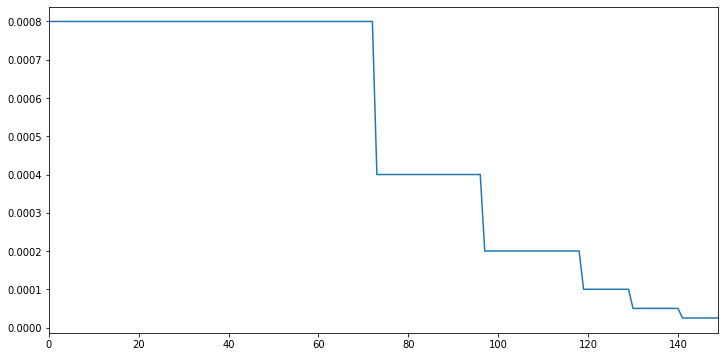

In [8]:
log['lr'].plot(figsize=(12,6));

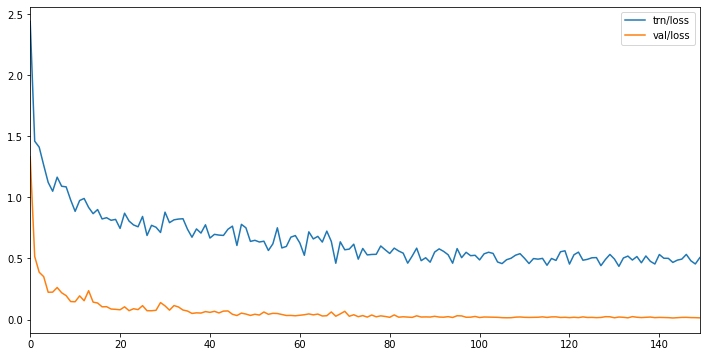

In [9]:
log[['trn/loss','val/loss']].plot(figsize=(12,6));

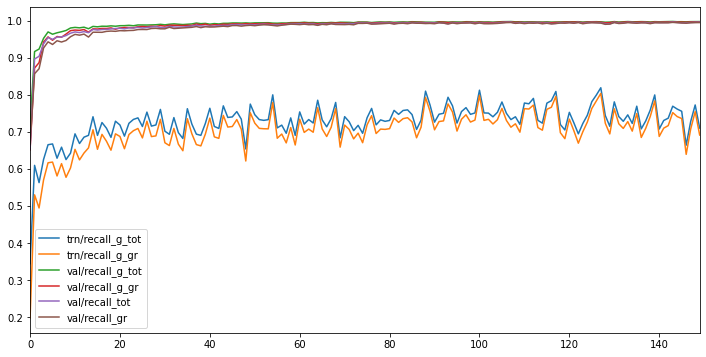

In [12]:
metric_cols = ['trn/recall_g_tot','trn/recall_g_gr','val/recall_g_tot','val/recall_g_gr','val/recall_tot','val/recall_gr']
log[metric_cols].plot(figsize=(12,6));